# Binned plots for the observations climatology
All years (4 DJF, 5 JJA) on ONE binned plot for each region; 5 figs, 4 panels
1. bin-mean cloud ice (all points)
2. bin counts (all points)
3. bin-mean cloud ice (both instr)
4. bin counts (both instr)
5. bin-mean effective radius (both instr)

# TODO: dictionary mapping region abbreviations to long names for titles
e.g., "ECP" --> "East-Central Pacific"

I think this will be much more readable than keeping the abbreviations in the paper!


In [1]:
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts")
import dask
import pickle

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import bin_obs_overshoot as boo

from dask.diagnostics import ProgressBar
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


#### TODO: put this in a bin_climo.py script?

In [2]:
season = "DJF"

if season == "DJF":
    region_list = ["AMZ", "SPC", "ECP", "IOS"]
    year_list = [2007, 2008, 2009, 2010]
    
elif season == "JJA":
    region_list = ["AFR", "WPC", "ECP", "IOE"]
    year_list = [2007, 2008, 2009, 2010] # TODO: add 2006 when done
    
years_sorted = list(sorted(year_list))
years_str = str(years_sorted[0]) + "-" + str(years_sorted[-1])
print(years_str)


2007-2010


### Make or load the dictionaries

##### ~3-5 min for DJF; ~6-7 min for JJA:

In [3]:
save_dicts = False
file_path = "/work/bb1153/b380887/big_obs_climo/"


In [4]:
%%time

# you only need to read these files in if you have to make the dictionaries
if save_dicts:
    dar_dict = {}
    tb_dict = {}

    for region in region_list:
        dar_list = [[]]*len(year_list)
        tb_list = [[]]*len(year_list)

        for i, year in enumerate(year_list):
            if region == "SPC":
                ds_all_1 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}1.nc".format(s=season, y=year, r=region))
                ds_all_2 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}2.nc".format(s=season, y=year, r=region))            
                tb_1 = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}1.nc4".format(s=season, y=year, r=region))
                tb_2 = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}2.nc4".format(s=season, y=year, r=region))

                tb_dar_1 = tb_1["Tb"].sel(time=ds_all_1["iwc_cp"].time, lat=ds_all_1["iwc_cp"].lat, lon=ds_all_1["iwc_cp"].lon, method="nearest")
                tb_dar_2 = tb_2["Tb"].sel(time=ds_all_2["iwc_cp"].time, lat=ds_all_2["iwc_cp"].lat, lon=ds_all_2["iwc_cp"].lon, method="nearest")

                dar_list[i] = xr.concat([ds_all_1, ds_all_2], dim="time")
                tb_list[i] = xr.concat([tb_dar_1, tb_dar_2], dim="time")

            else:
                ds_all = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))
                tb = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}.nc4".format(s=season, y=year, r=region))
                tb_list[i] = tb["Tb"].sel(time=ds_all["iwc_cp"].time, lat=ds_all["iwc_cp"].lat, lon=ds_all["iwc_cp"].lon, method="nearest")
                dar_list[i] = ds_all

        dar_dict[region] = xr.concat(dar_list, dim="time")
        tb_dict[region] = xr.concat(tb_list, dim="time")
        print(region + " done")

                            

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


In [5]:
file_path = "/work/bb1153/b380887/big_obs_climo/{}/".format(season)
pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/binned_by_tb/climo/new_bins/"


In [6]:
qi_means_dict = {}
qi_counts_dict = {}
re_means_dict = {}
re_counts_dict = {}
qi3_means_dict = {}
qi3_counts_dict = {}


for region in region_list:
    # save dicts if needed
    if save_dicts:
        output_qi = boo.bin_var_by_tb(dar_dict[region], tb_dict[region], "qi", 
                                      save_dicts=save_dicts, pickle_dir=pickle_dir,
                                      month=season, year=years_str, region=region) 
        output_re = boo.bin_var_by_tb(dar_dict[region], tb_dict[region], "Re", save_dicts=save_dicts, pickle_dir=pickle_dir,
                                   month=season, year=years_str, region=region, iflag=3)
        output_qi3 = boo.bin_var_by_tb(dar_dict[region], tb_dict[region], "qi", save_dicts=save_dicts, pickle_dir=pickle_dir,
                                       month=season, year=years_str, region=region, iflag=3)


### Now plot

In [7]:
def plot_binned_by_tb_gs(region_bin_dict, region_tb_counts_dict, statistic, month, year, bins,
                          stat_lims=None, fsize=26, tsize=30, figsize=(33, 18), tb_count_lims=(1, 1000),
                           colormap="Spectral", cbar_ext="max", lognorm=True, save=False,
                          save_dir=None, varname="qi", save_extr=""): 
    """
    Plot DARDAR qi values binned by MERGIR brightness temperatures at levels relative to the cold 
    point. Variable "statistic" is "count" or "mean". Plots the Tb bin count at the bottom instead of
    the -1000m level.
    """
    regions = list(region_bin_dict.keys())
    
    if varname == "qi":
        long_name = "cloud ice"
        units = "kg/kg"
    elif varname == "reff":
        long_name = "effective radius"
        units = "$\mu m$"
        
    if stat_lims is None:
        if statistic == "mean":
            if varname == "reff":
                stat_lims = (0, 100)
            elif varname == "qi":
                stat_lims = (1e-6, 5e-4)
        elif statistic == "count":
            stat_lims = (1, 1000)

    
    ind_offsets = [-2, -1, 0, 1, 2]  
    offset_labs = [
        "T$_b$ bin counts",
        "~500 m below",
        "At cold point",
        "~500 m above",
        "~1000 m above"
    ]
    
    # set up figure
    fig = plt.figure(figsize=figsize)#, constrained_layout=True)
    gs = GridSpec(4, 11, figure=fig, height_ratios=[0.25, 5, 5, 0.5], hspace=0.7, wspace=0.1)
    ax_title = fig.add_subplot(gs[0, 4:7])
    ax1 = fig.add_subplot(gs[1, :5])
    ax2 = fig.add_subplot(gs[1, 6:])
    ax3 = fig.add_subplot(gs[2, :5])
    ax4 = fig.add_subplot(gs[2, 6:])
    ax_cb1 = fig.add_subplot(gs[-1, :5])
    ax_cb2 = fig.add_subplot(gs[-1, 6:])
    axes_list = [ax1, ax2, ax3, ax4]
        
    # plot 
    bin_mean_values = (bins[:-1] + bins[1:])/2
    for i, region in enumerate(regions):
        bin_dict = region_bin_dict[region]
        tb_counts = region_tb_counts_dict[region]
        ax = axes_list[i]
        
        # turn the values into arrays
        bin_dict_arr = np.array(list(bin_dict.values()))[1:, :]
        if varname == "reff":
            bin_dict_arr = bin_dict_arr*1e6 # convert from m --> um
        tiled_counts = np.zeros((len(ind_offsets), len(tb_counts)))
        tiled_counts[0, :] = tb_counts
        tiled_counts[1:, :] = np.nan
        
        # plot binned values
        if lognorm:
            pcm1 = ax.pcolormesh(bin_mean_values, ind_offsets[1:], bin_dict_arr, cmap=colormap,
                                 norm=mcolors.LogNorm(vmin=stat_lims[0], vmax=stat_lims[1]))
        else:
            pcm1 = ax.pcolormesh(bin_mean_values, ind_offsets[1:], bin_dict_arr, cmap=colormap,
                                 vmin=stat_lims[0], vmax=stat_lims[1])
        # plot Tb bin counts
        if statistic == "count": 
            tb_cmap = "Spectral"
        else: 
            tb_cmap = "coolwarm"
        pcm2 = ax.pcolormesh(bin_mean_values, ind_offsets, tiled_counts,
                      cmap=tb_cmap, norm=mcolors.LogNorm(vmin=tb_count_lims[0], vmax=tb_count_lims[1])
                    )
        ax.set_title(region, fontsize=tsize)
        
        # format axes (all)
        ax.tick_params(axis="y", labelsize=fsize-2, length=0)
        ax.set_xticks(bins[::4])        
        ax.tick_params(axis="x", rotation=45, labelsize=fsize-1)
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(2))
        ax.tick_params(which='minor', length=10)
        ax.tick_params(which='major', length=14)

        # add horizontal borders
        for ind in ind_offsets[:-1]:
            if ind == -2:
                lw = 8
            else:
                lw = 2
            gap = 0.5
            ax.axhline(ind+0.5, color="k", linewidth=lw)
            
    # only y tick labels on left subplots
    for ax in [ax1, ax3]:
        ax.set_yticks(ind_offsets)
        ax.set_yticklabels(offset_labs)
    for ax in [ax2, ax4]:
        ax.set_yticks([])
        
    # only x axis labels on bottom subplots
    for ax in [ax3, ax4]:
        ax.set_xlabel("Brightness temperature (K)", fontsize=fsize)

    # binned values colorbar
    axins1 = inset_axes(ax_cb1, width="100%", height="80%", loc='center')
    ax_cb1.axis("off")
    cb1 = plt.colorbar(pcm1, cax=axins1, extend=cbar_ext, orientation="horizontal")
    cb1.ax.tick_params(labelsize=fsize-2)
    if statistic == "count":
        cb1.set_label("Cold point-relative bin counts", fontsize=fsize-2)
    elif statistic == "mean":
        cb1.set_label("Bin-mean {n} ({u})".format(n=long_name, u=units), fontsize=fsize-2)
        
    # Tb bin count colorbar
    axins2 = inset_axes(ax_cb2, width="100%", height="80%", loc='center')
    ax_cb2.axis("off")
    cb2 = plt.colorbar(pcm2, cax=axins2, extend="max", orientation="horizontal")
    cb2.ax.tick_params(labelsize=fsize-2)
    cb2.set_label("Brightness temperature (T$_b$) bin counts", fontsize=fsize-2)
    
    # title
    ax_title.axis("off")
    ax_title.text(x=0.5, y=0, s="{m} {y}".format(m=month, y=year), verticalalignment="top",
                  horizontalalignment="center", fontsize=tsize+7
                  )

    if save:
        if save_dir is None:
            raise Exception("Must provide save_dir if you want to save the plot")           
        plt.savefig(save_dir + "DARDAR_{v}_binned_by_Tb_with_counts_{s}_{m}{y}_{e}.png".format(
                                                                                            v=varname, s=statistic,
                                                                                            m=month, y=year, 
                                                                                            e=save_extr,
                                                                                        ),
                    dpi=300, bbox_inches="tight"
                   )

    plt.show()
    

#### Get the Tb counts

In [8]:
pickle_dir_hist = "/home/b/b380887/cold-point-overshoot/pickle_files/obs_tb_hists/"
pickle_dir_bin = "/home/b/b380887/cold-point-overshoot/pickle_files/binned_by_tb/climo/new_bins/"

region_tb_counts_dict = {}
qi_means_dict = {}
qi_counts_dict = {}
re_means_dict = {}
re_counts_dict = {}
qi3_means_dict = {}
qi3_counts_dict = {}

for region in region_list:
    with open(pickle_dir_hist + "Tb_histogram_dict_{s}{y}_{r}.pickle".format(r=region, y=years_str, s=season), "rb") as handle:
        tb_count_dict = pickle.load(handle)
    region_tb_counts_dict[region] = tb_count_dict["counts"]

    qi_means_dict[region], qi_counts_dict[region] = boo.load_saved_dicts("qi", season, region, years_str, pickle_dir_bin)
    re_means_dict[region], re_counts_dict[region] = boo.load_saved_dicts("Re", season, region, years_str, pickle_dir_bin, iflag=3)
    qi3_means_dict[region], qi3_counts_dict[region] = boo.load_saved_dicts("qi", season, region, years_str, pickle_dir_bin, iflag=3)
    

#### Make the plots

In [9]:
save_plots = True 
plot_save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/climo/new_bins/"

tb_bins = np.arange(186, 301, 2)
qi_lims = (1e-6, 1e-3)
count_lims=(1, 1e5)
reff_lims = (20, 60)
figsize = (30, 20)

ind_offsets = [-2, -1, 0, 1, 2] 
bin_mean_values = (tb_bins[:-1] + tb_bins[1:])/2


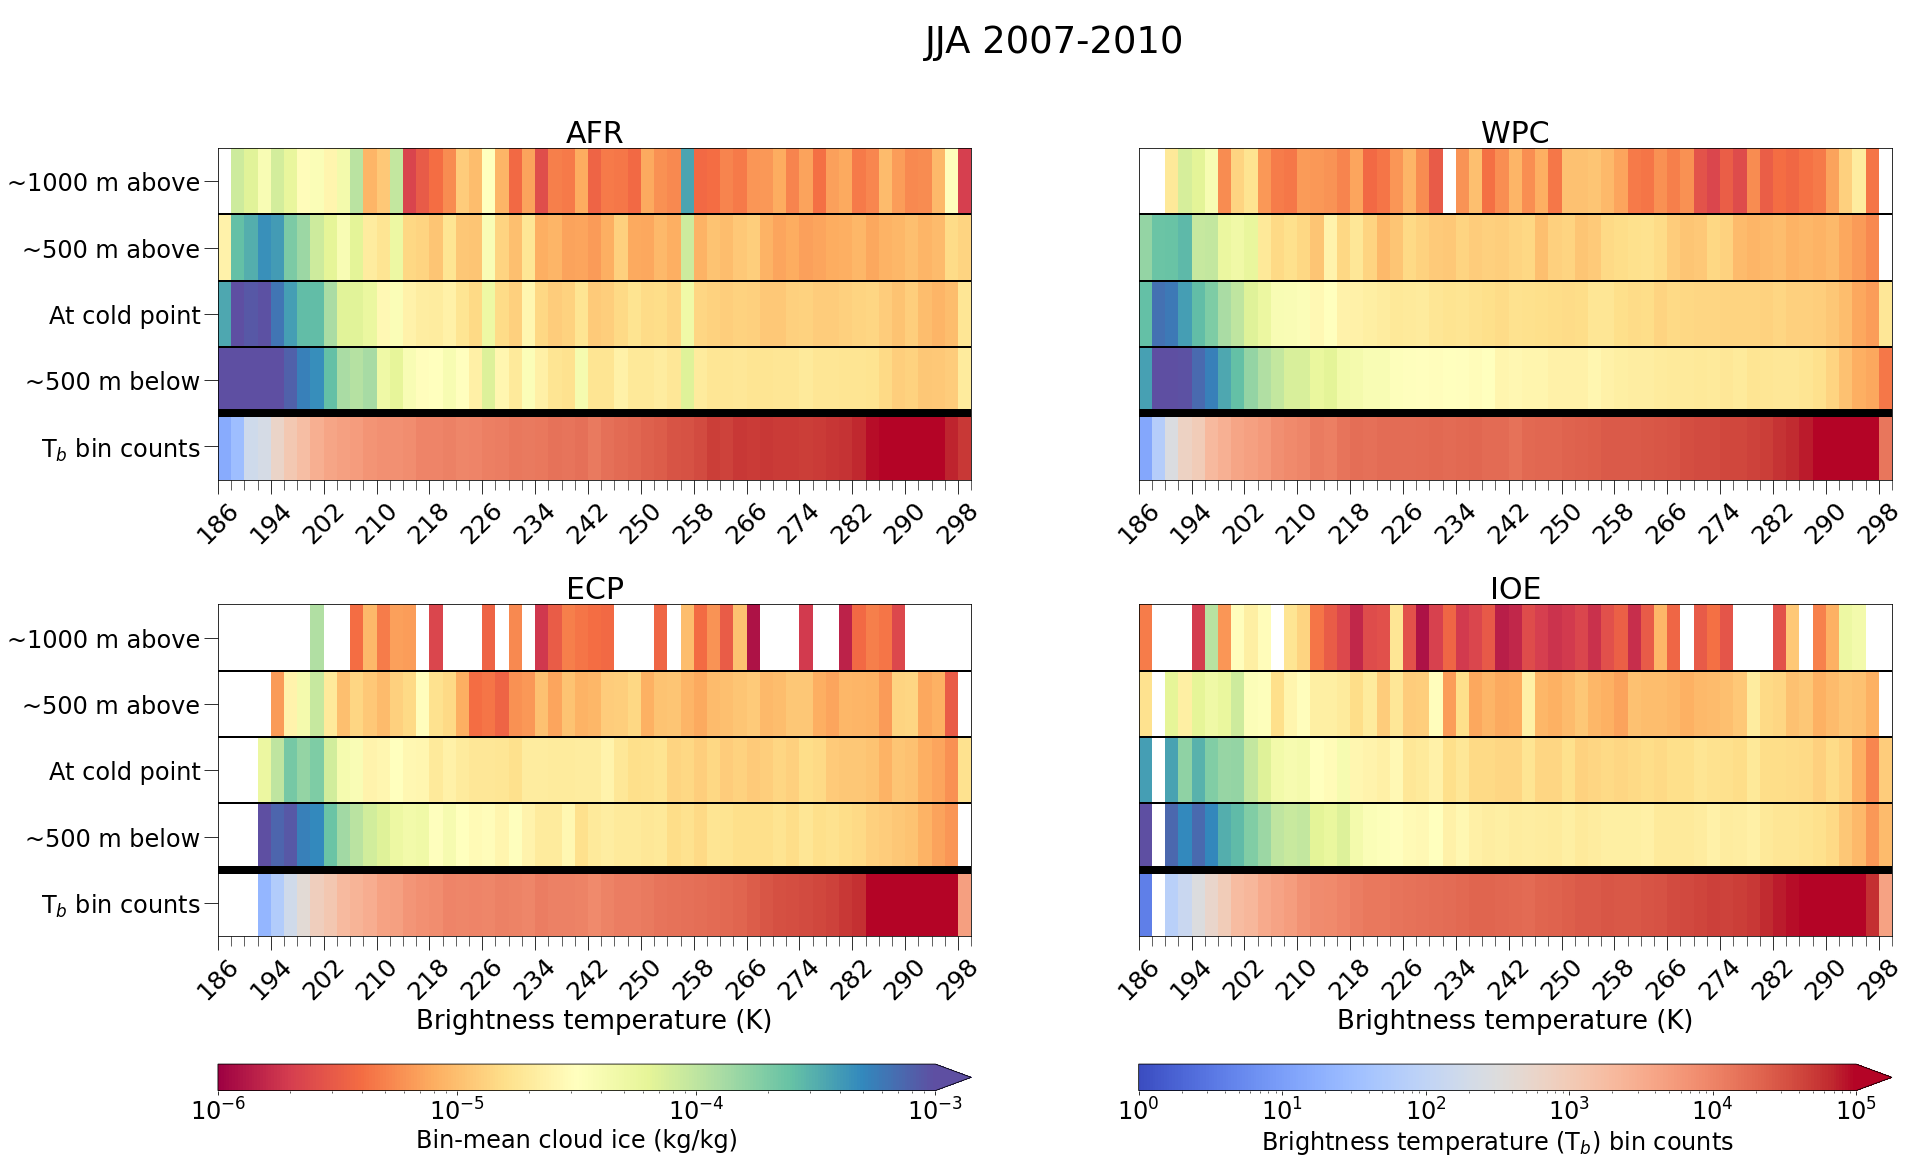

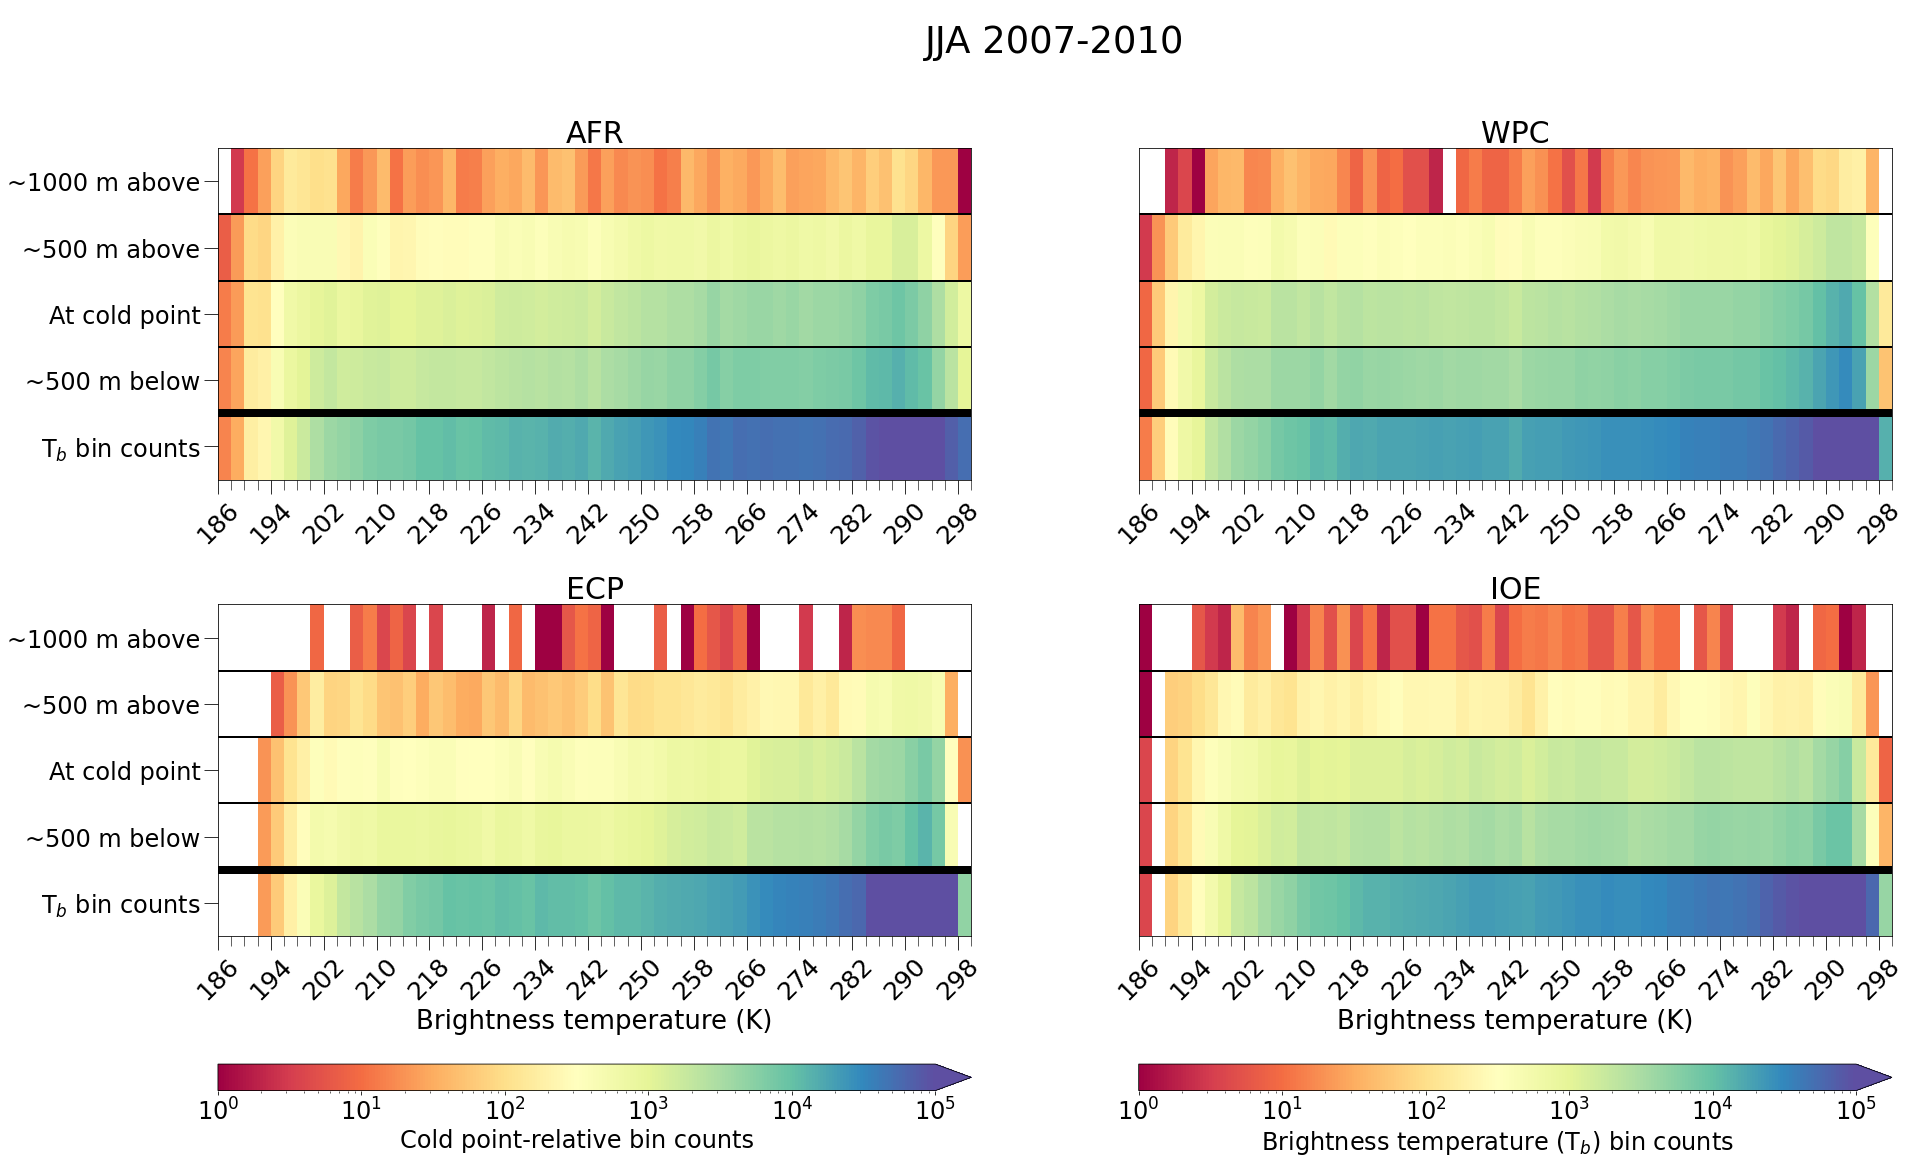

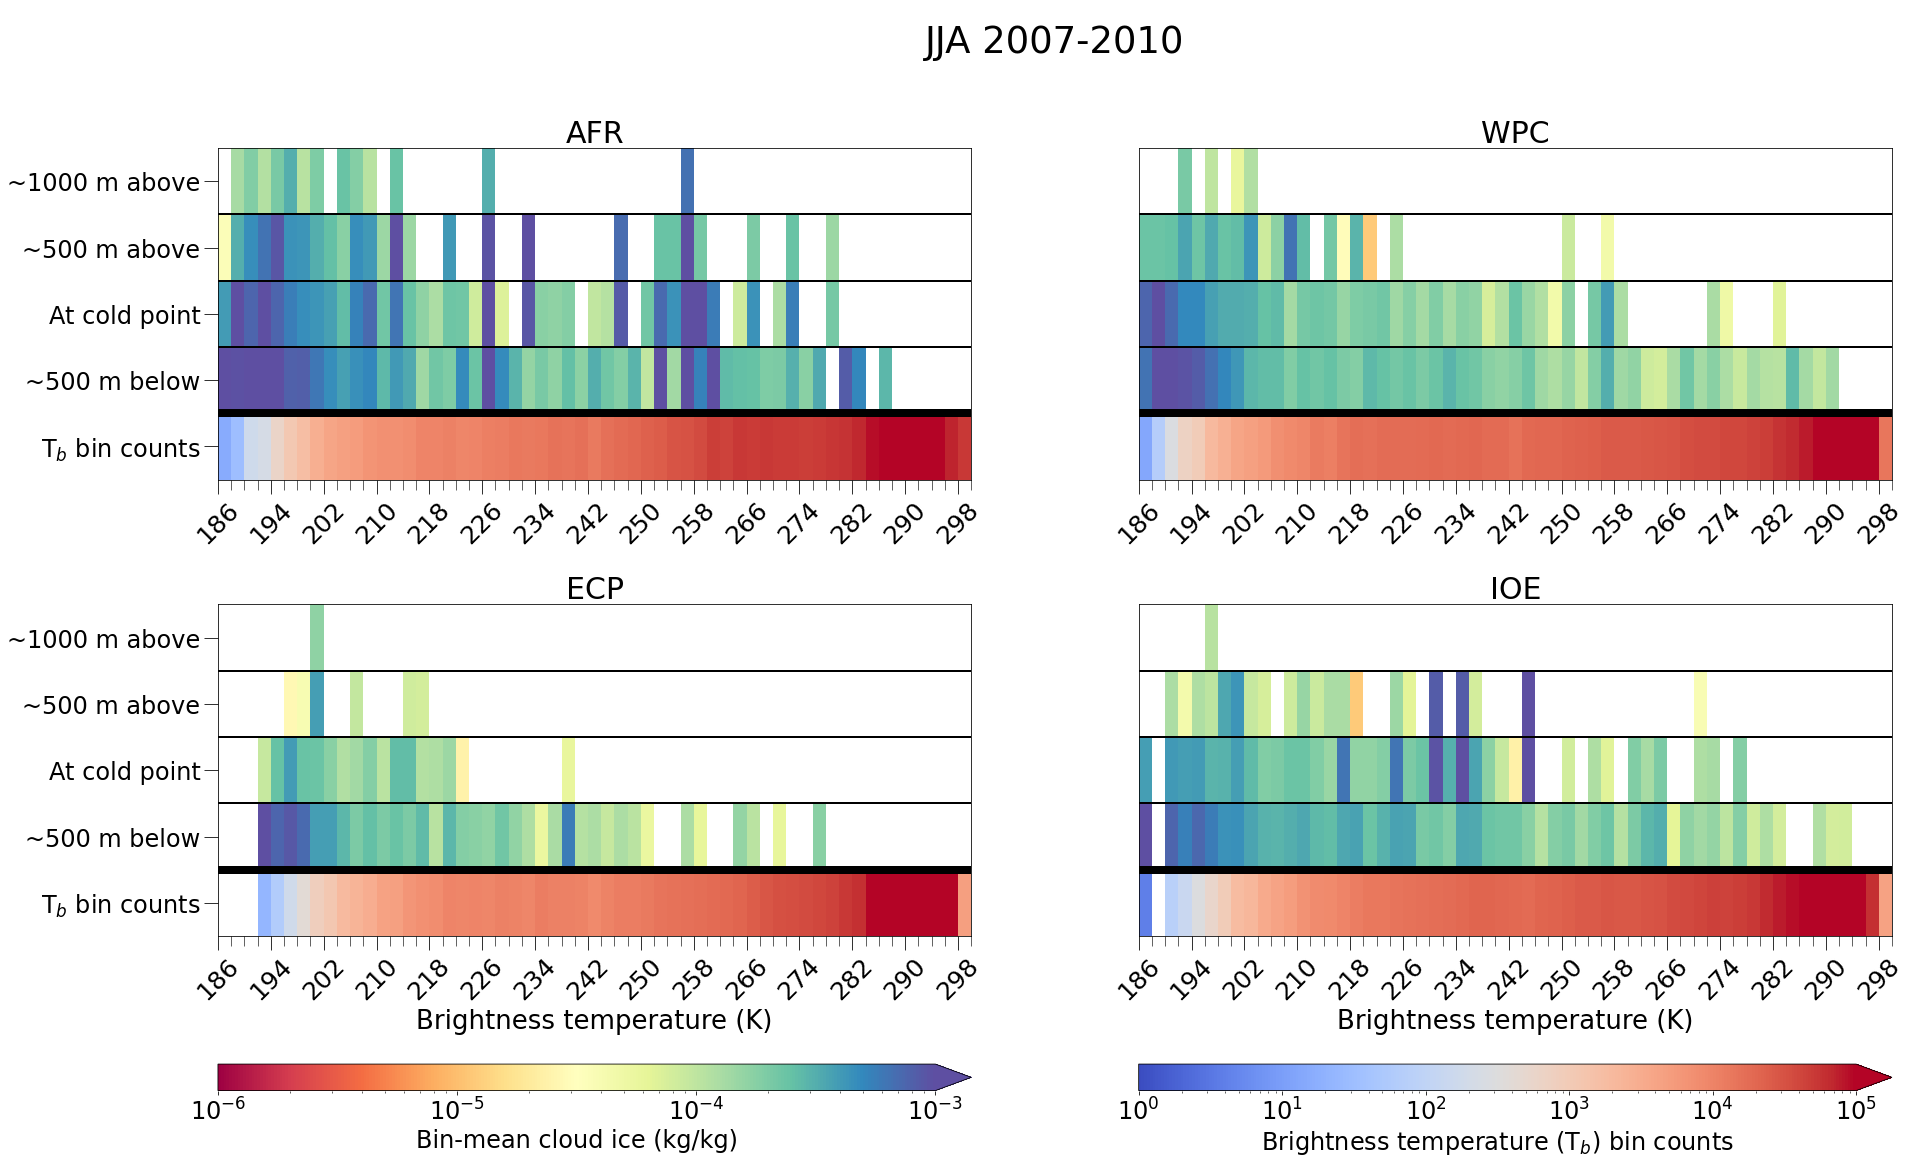

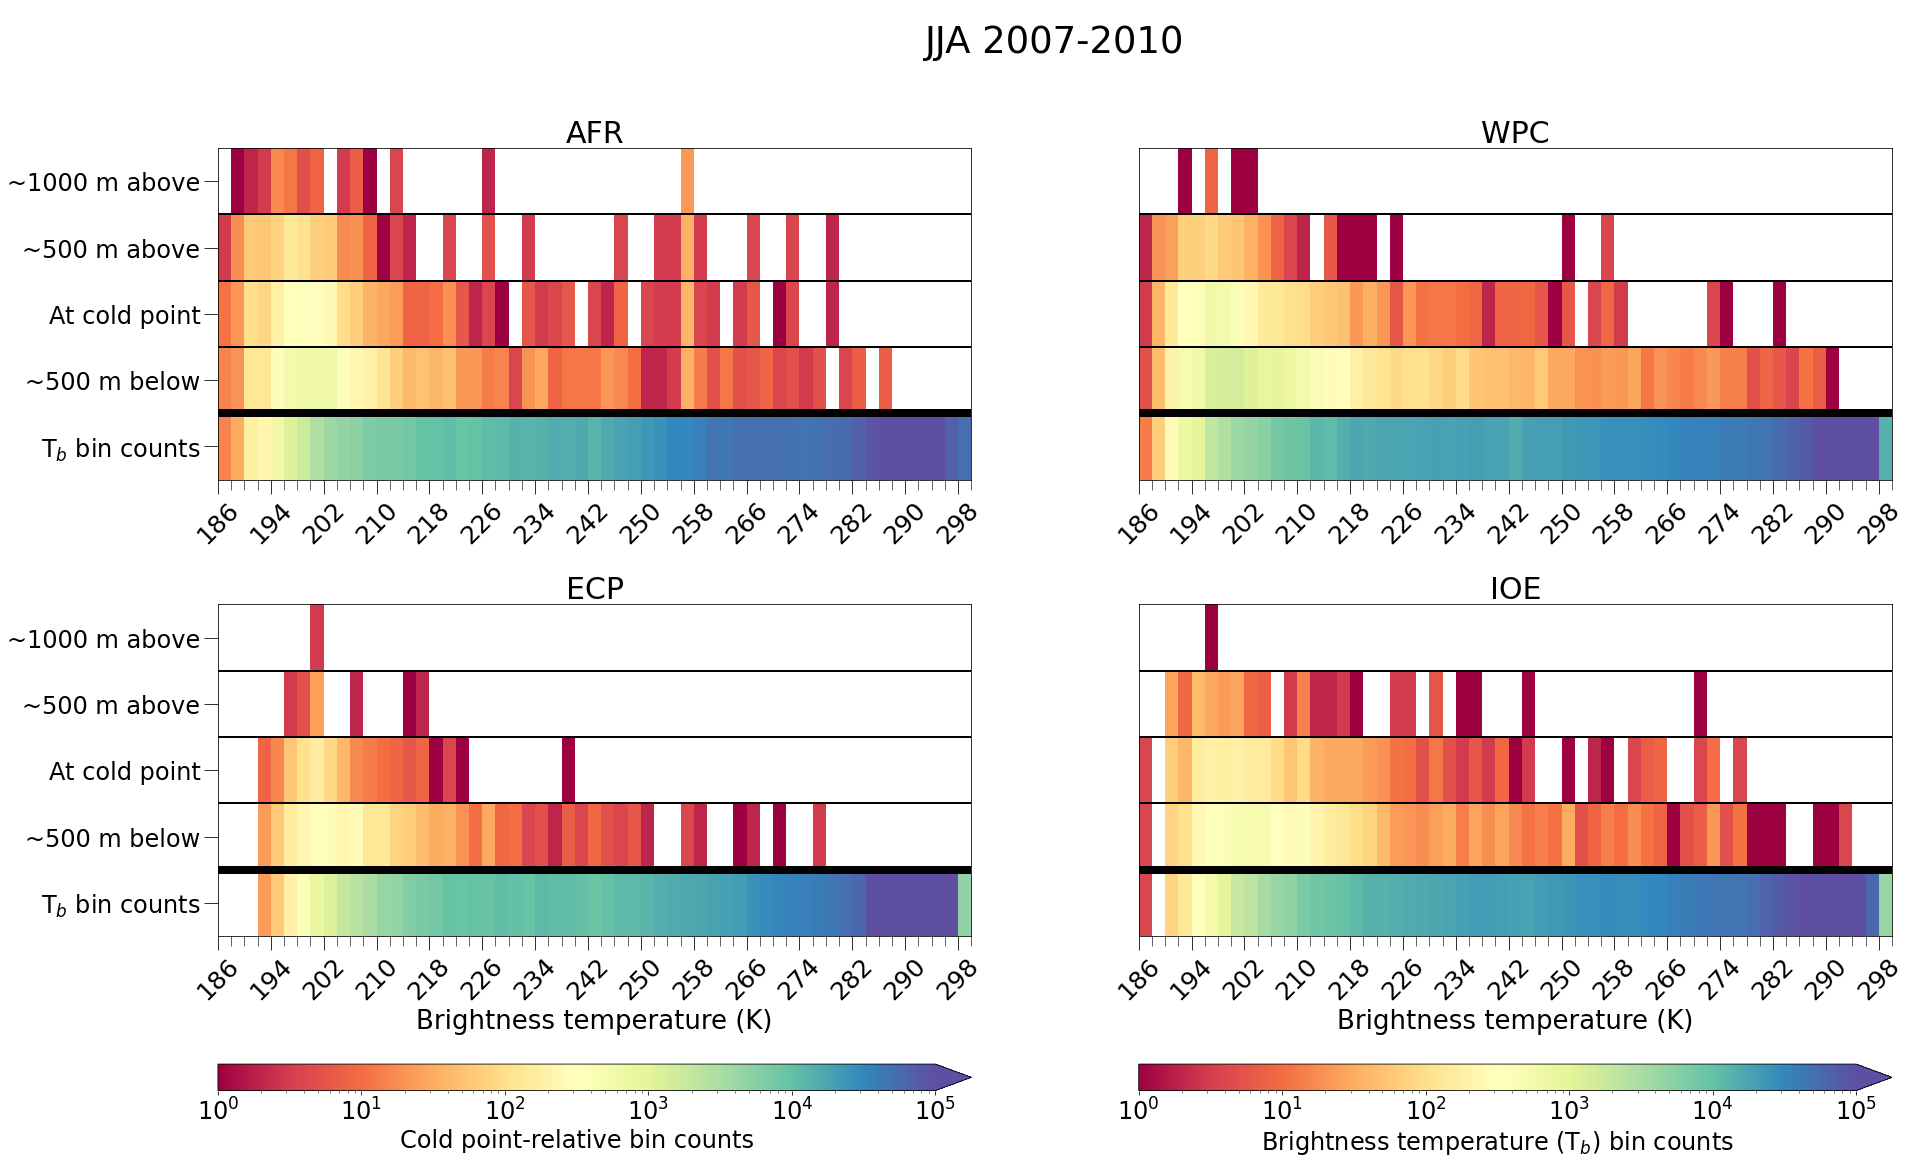

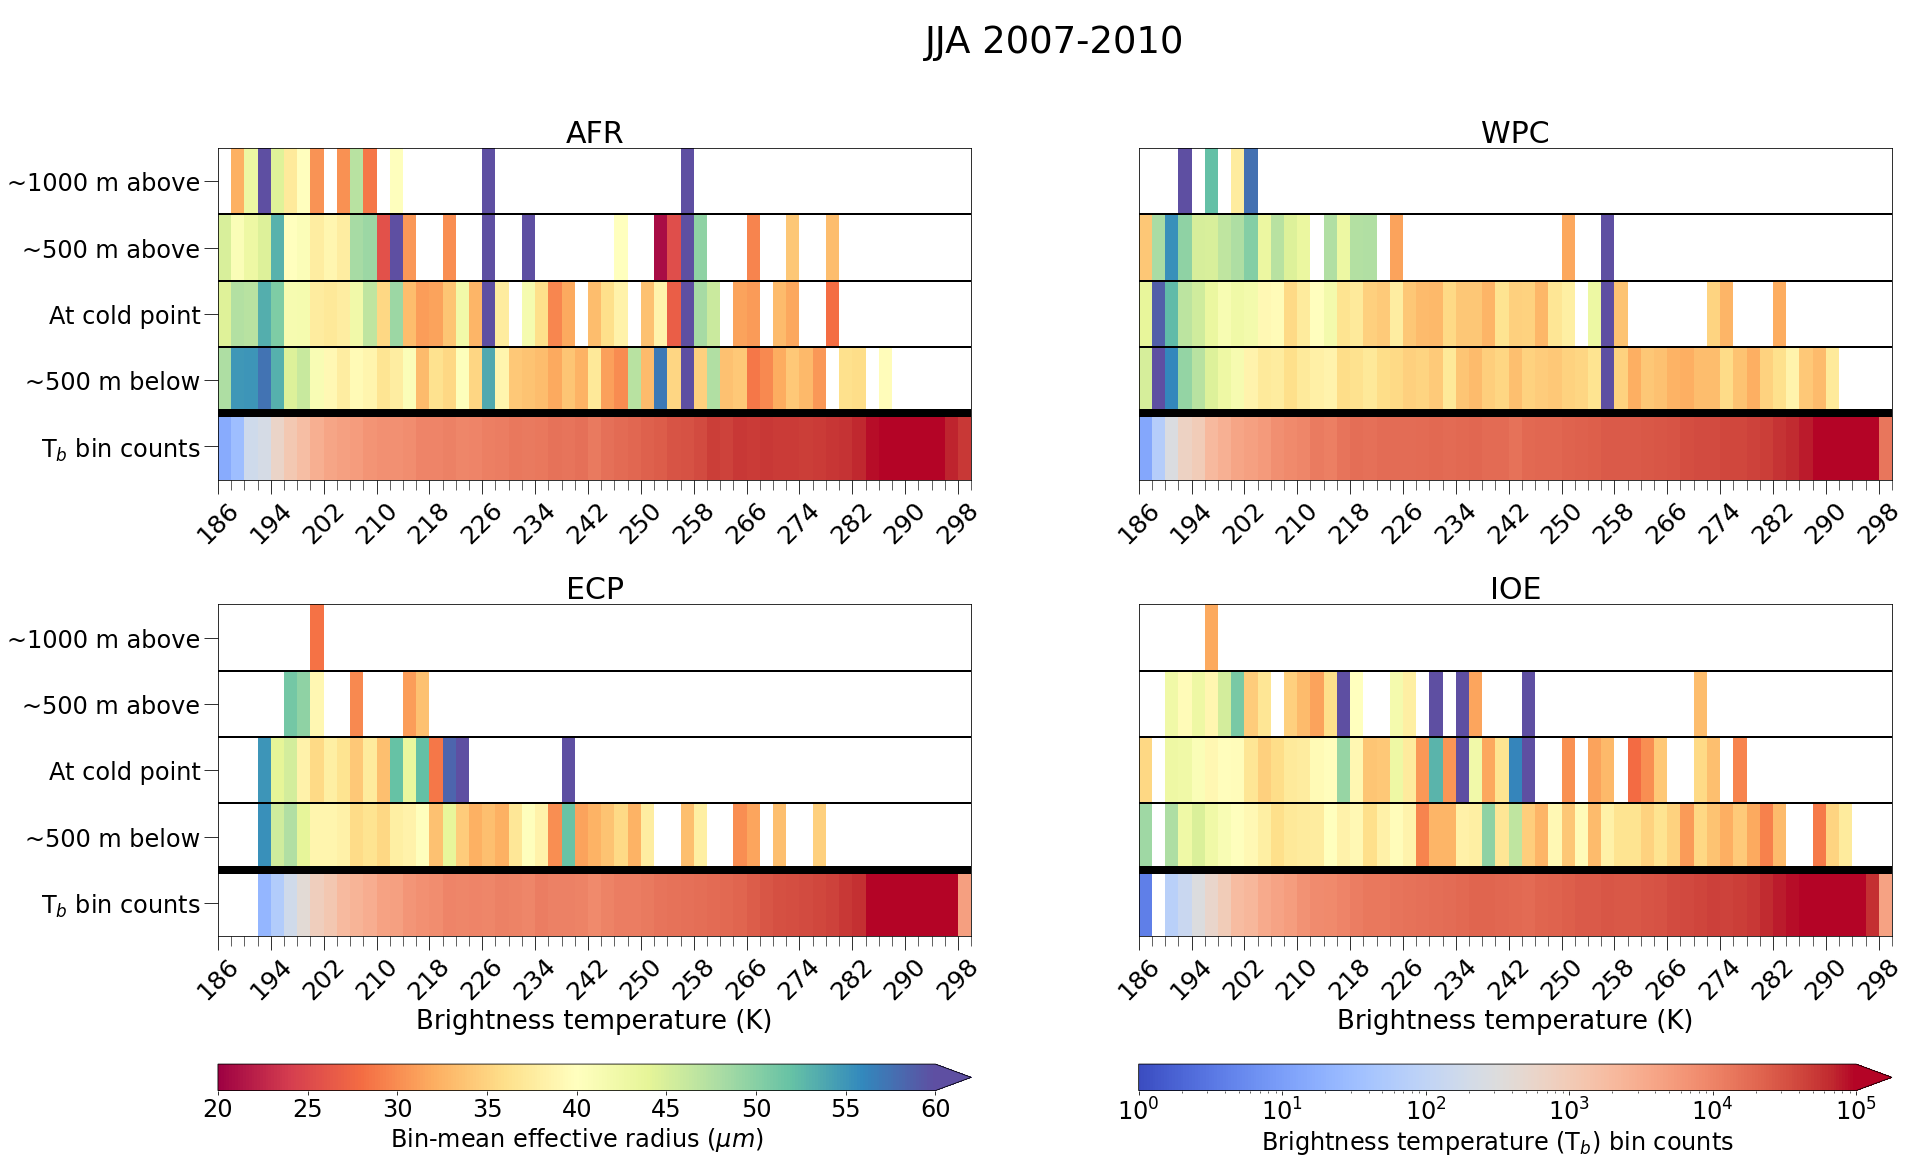

In [21]:
# JJA

plot_binned_by_tb_gs(qi_means_dict, region_tb_counts_dict, "mean", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, stat_lims=qi_lims, figsize=figsize,
                    tb_count_lims=count_lims)
plot_binned_by_tb_gs(qi_counts_dict, region_tb_counts_dict, "count", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, stat_lims=count_lims, figsize=figsize,
                    tb_count_lims=count_lims)

plot_binned_by_tb_gs(qi3_means_dict, region_tb_counts_dict, "mean", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, save_extr="_both_instr",
                      stat_lims=qi_lims, figsize=figsize, tb_count_lims=count_lims)
plot_binned_by_tb_gs(qi3_counts_dict, region_tb_counts_dict, "count", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, stat_lims=count_lims, save_extr="_both_instr",
                        figsize=figsize, tb_count_lims=count_lims)

plot_binned_by_tb_gs(re_means_dict, region_tb_counts_dict, "mean", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, save_extr="_both_instr",
                      varname="reff", lognorm=False, stat_lims=reff_lims, figsize=figsize, tb_count_lims=count_lims)
    

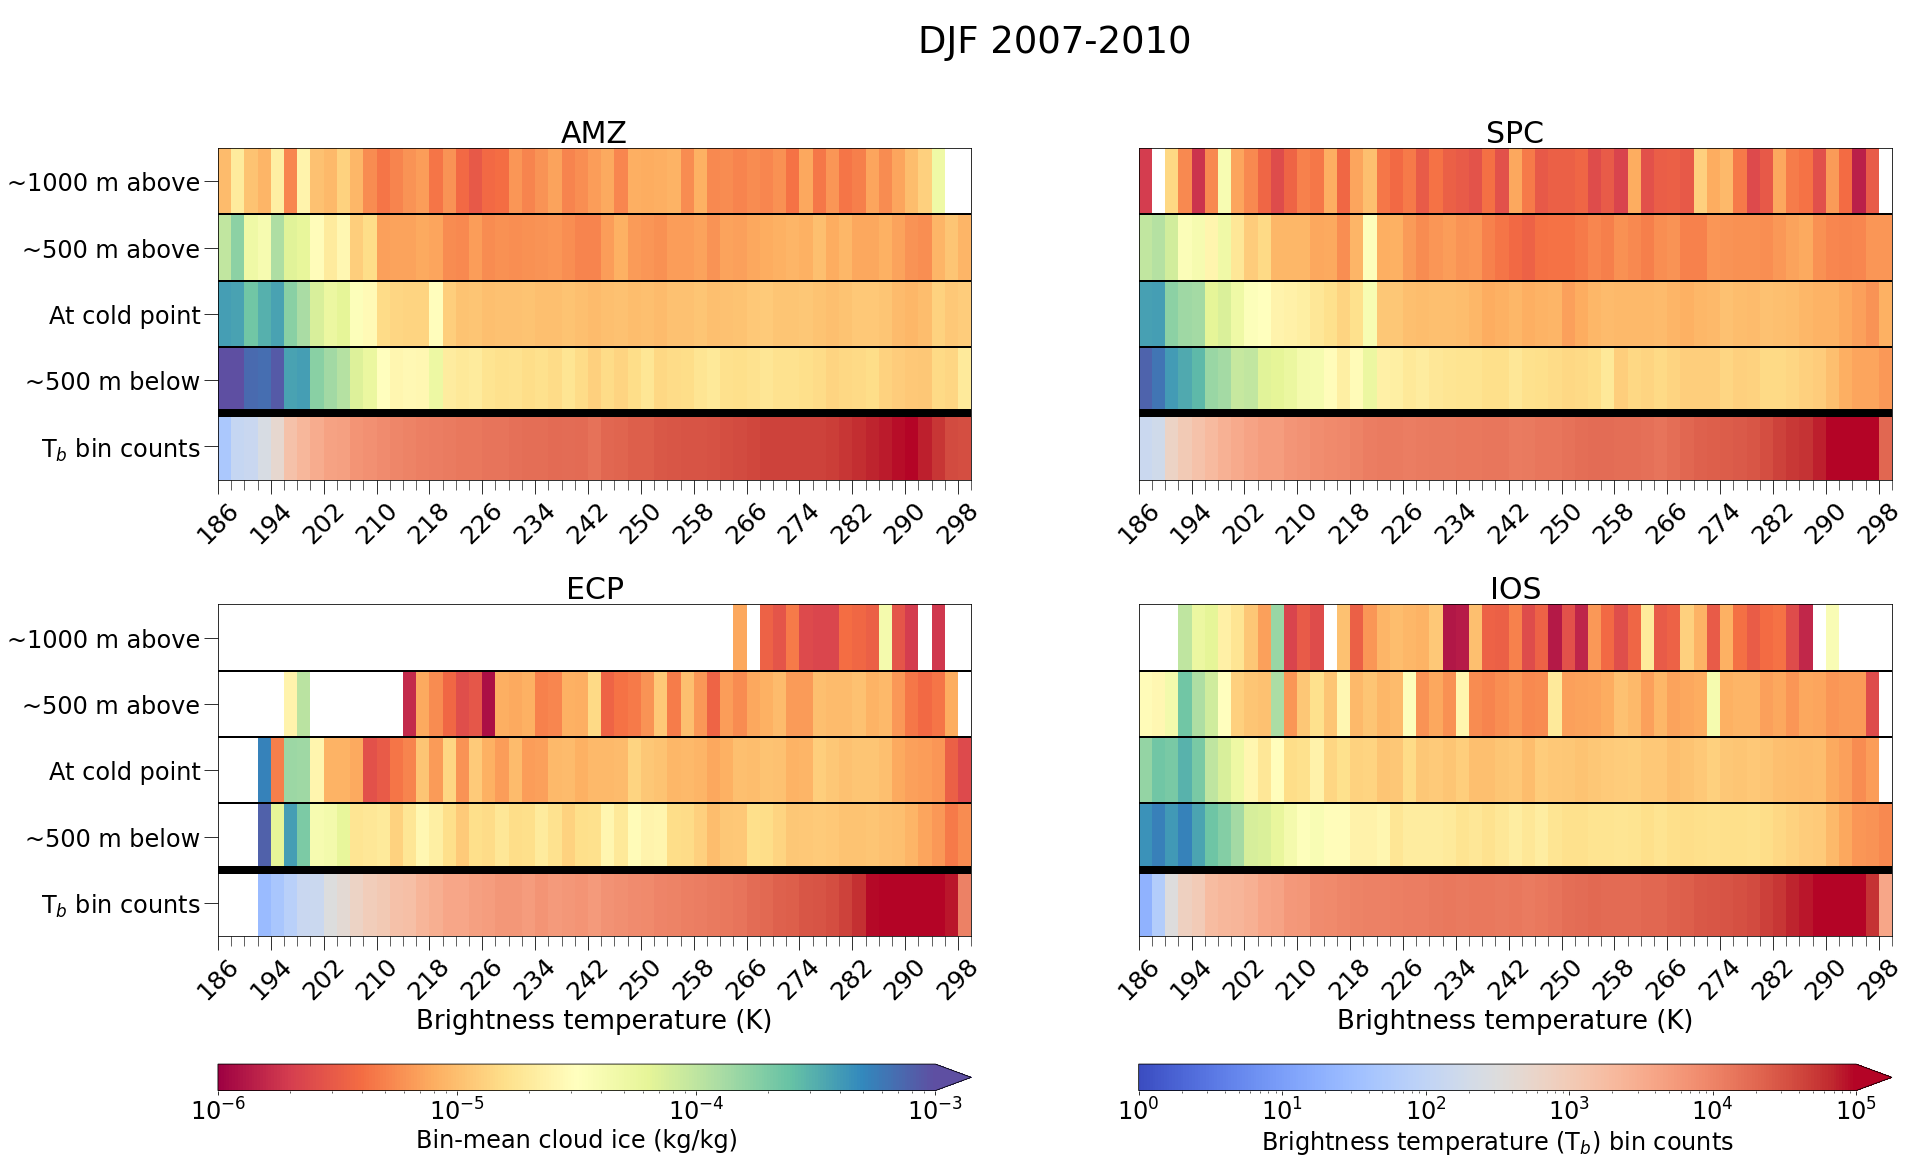

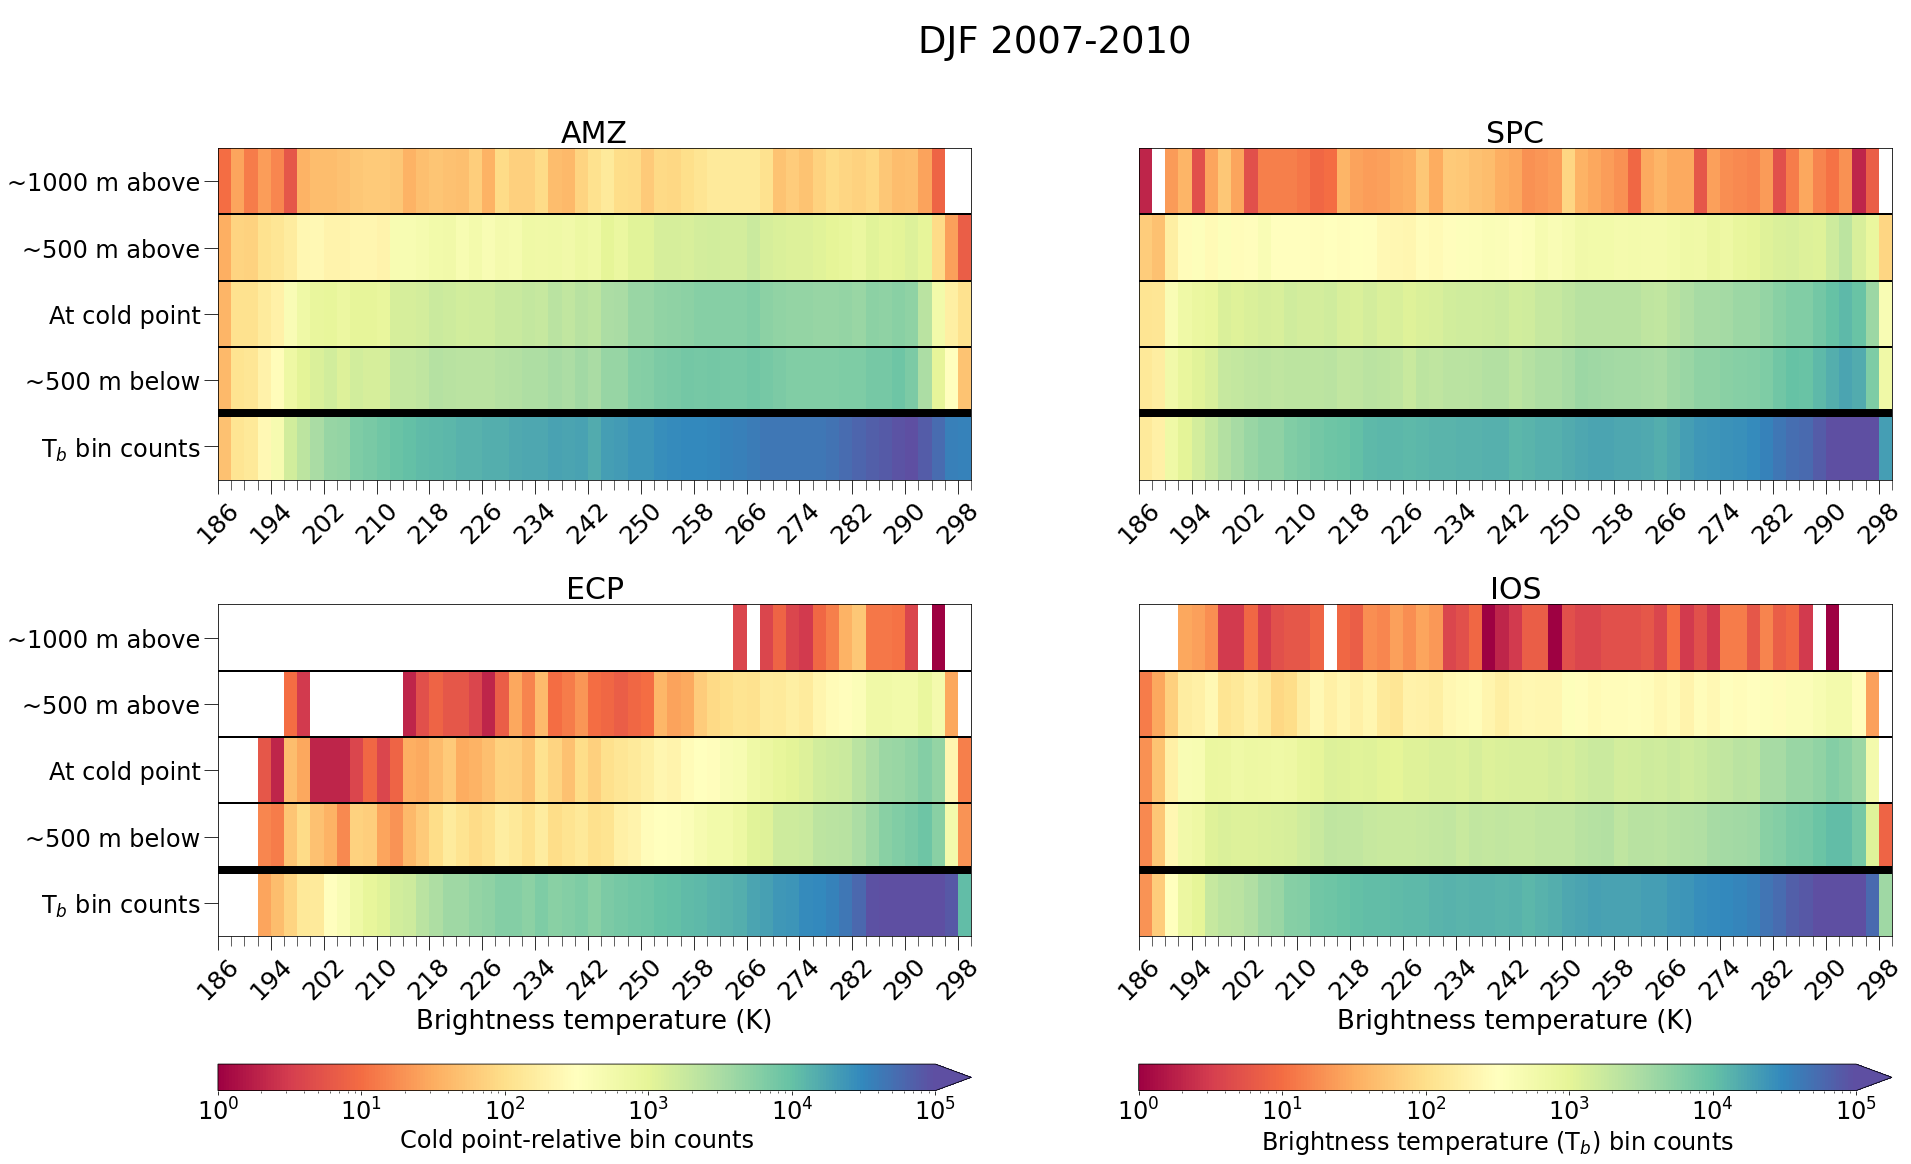

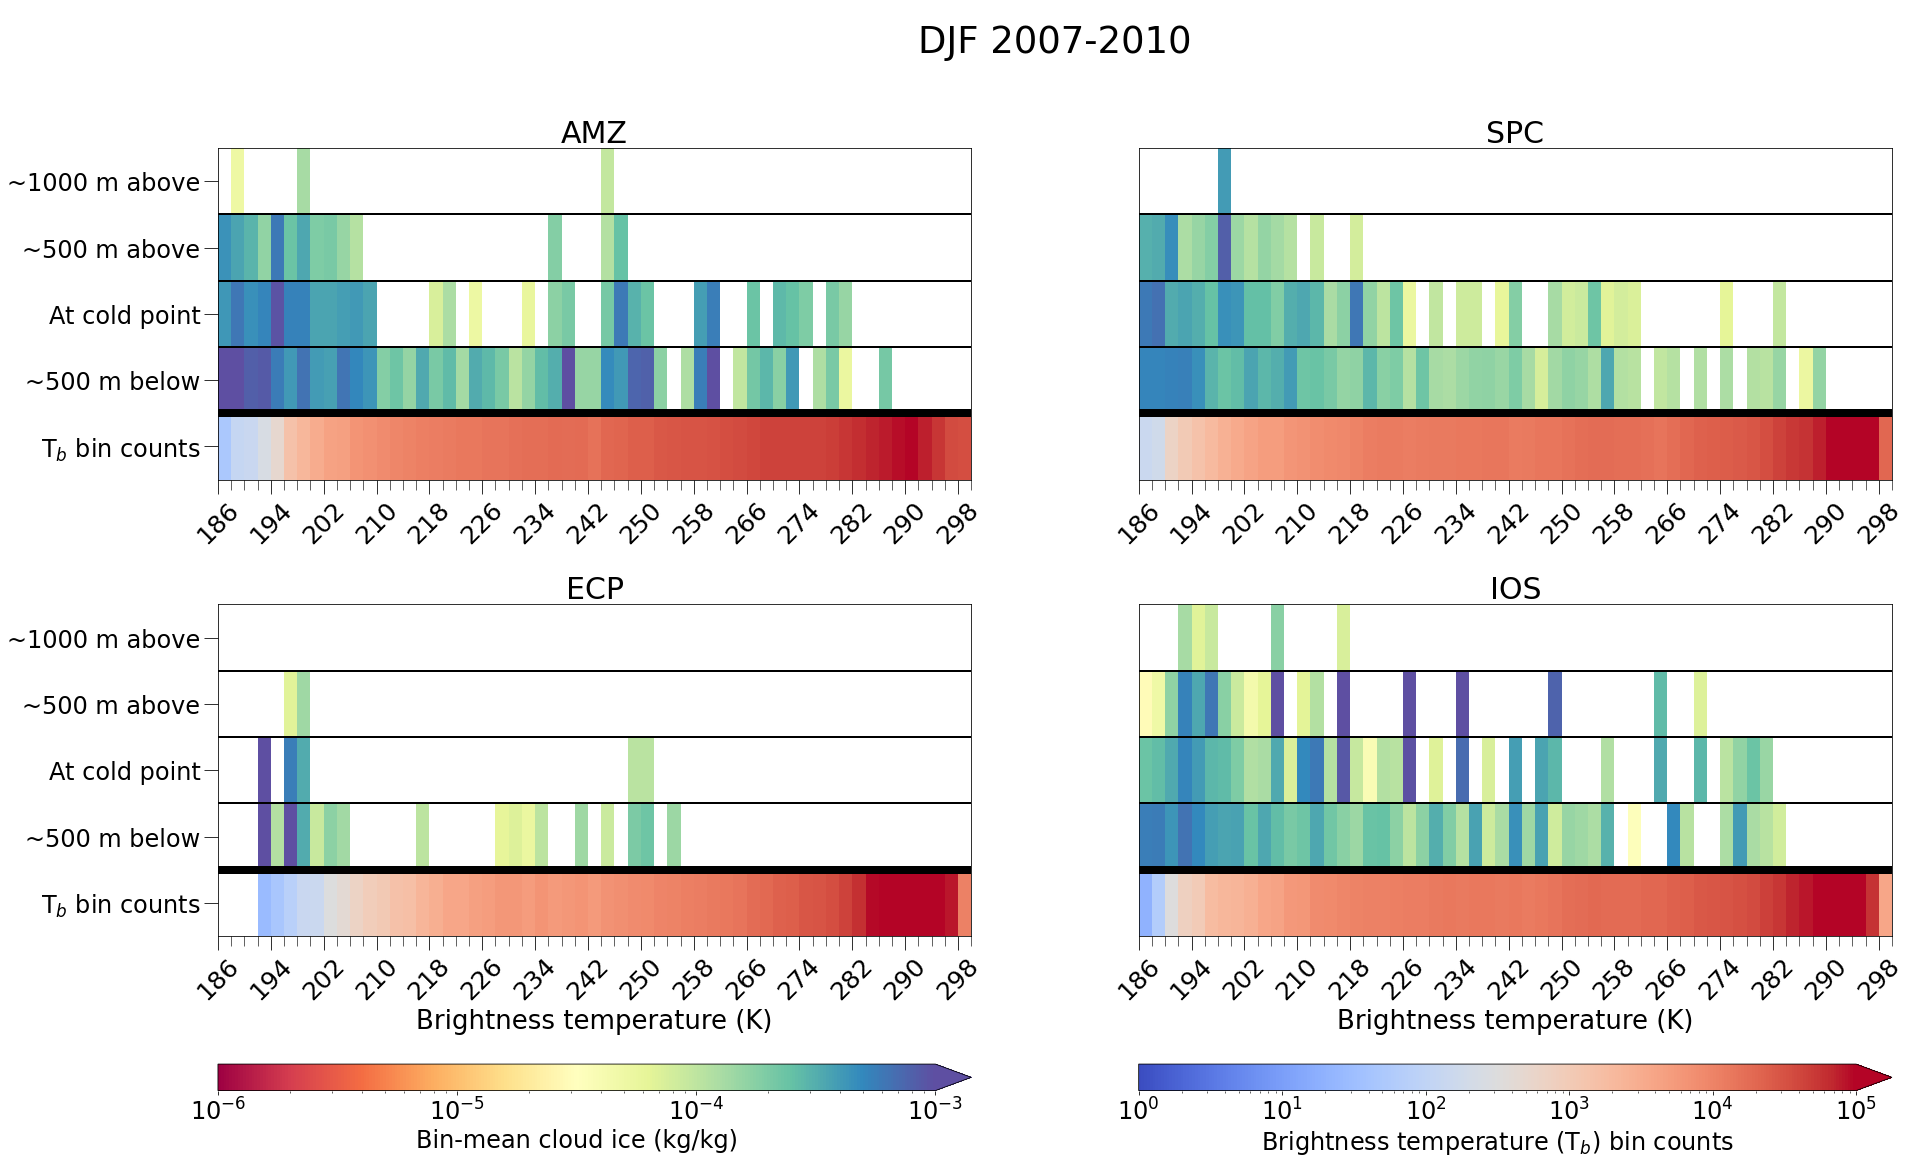

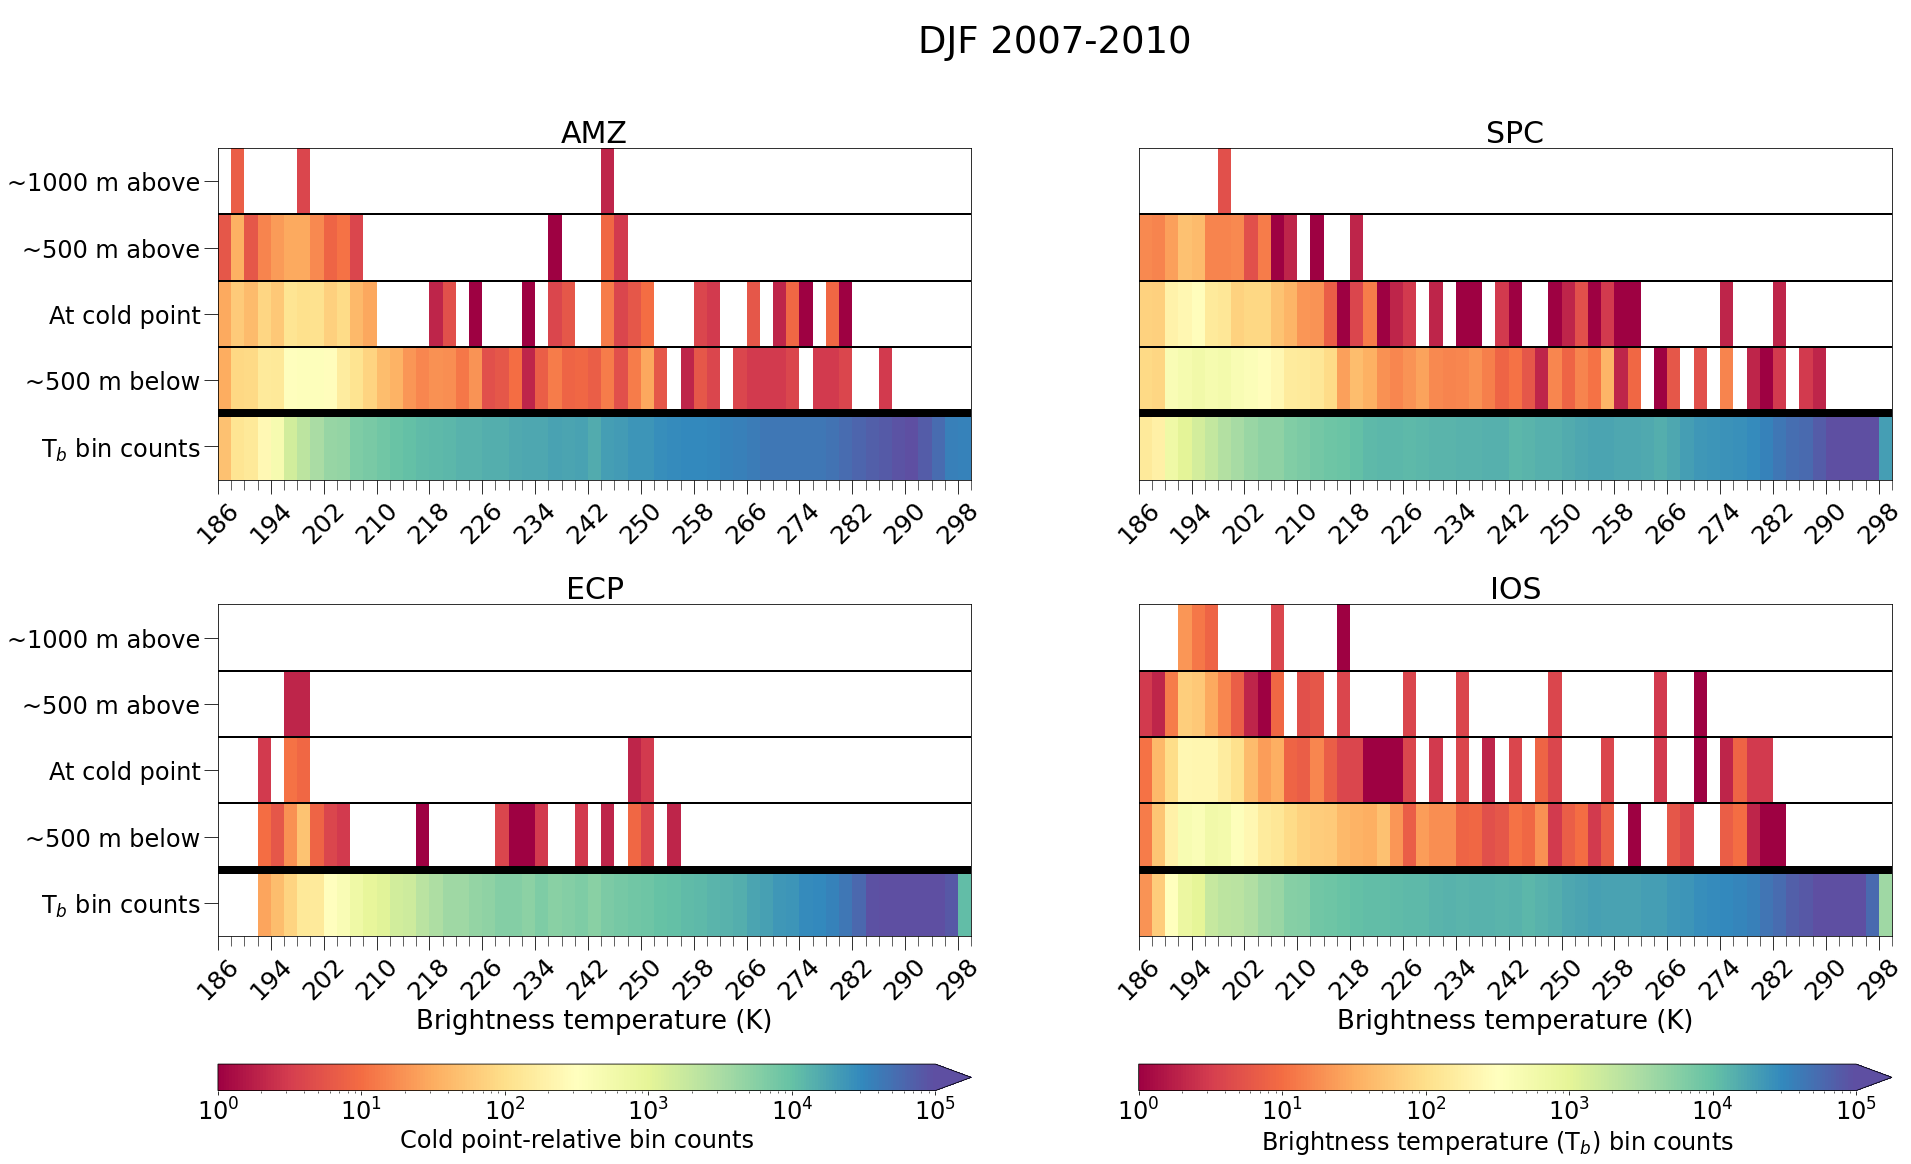

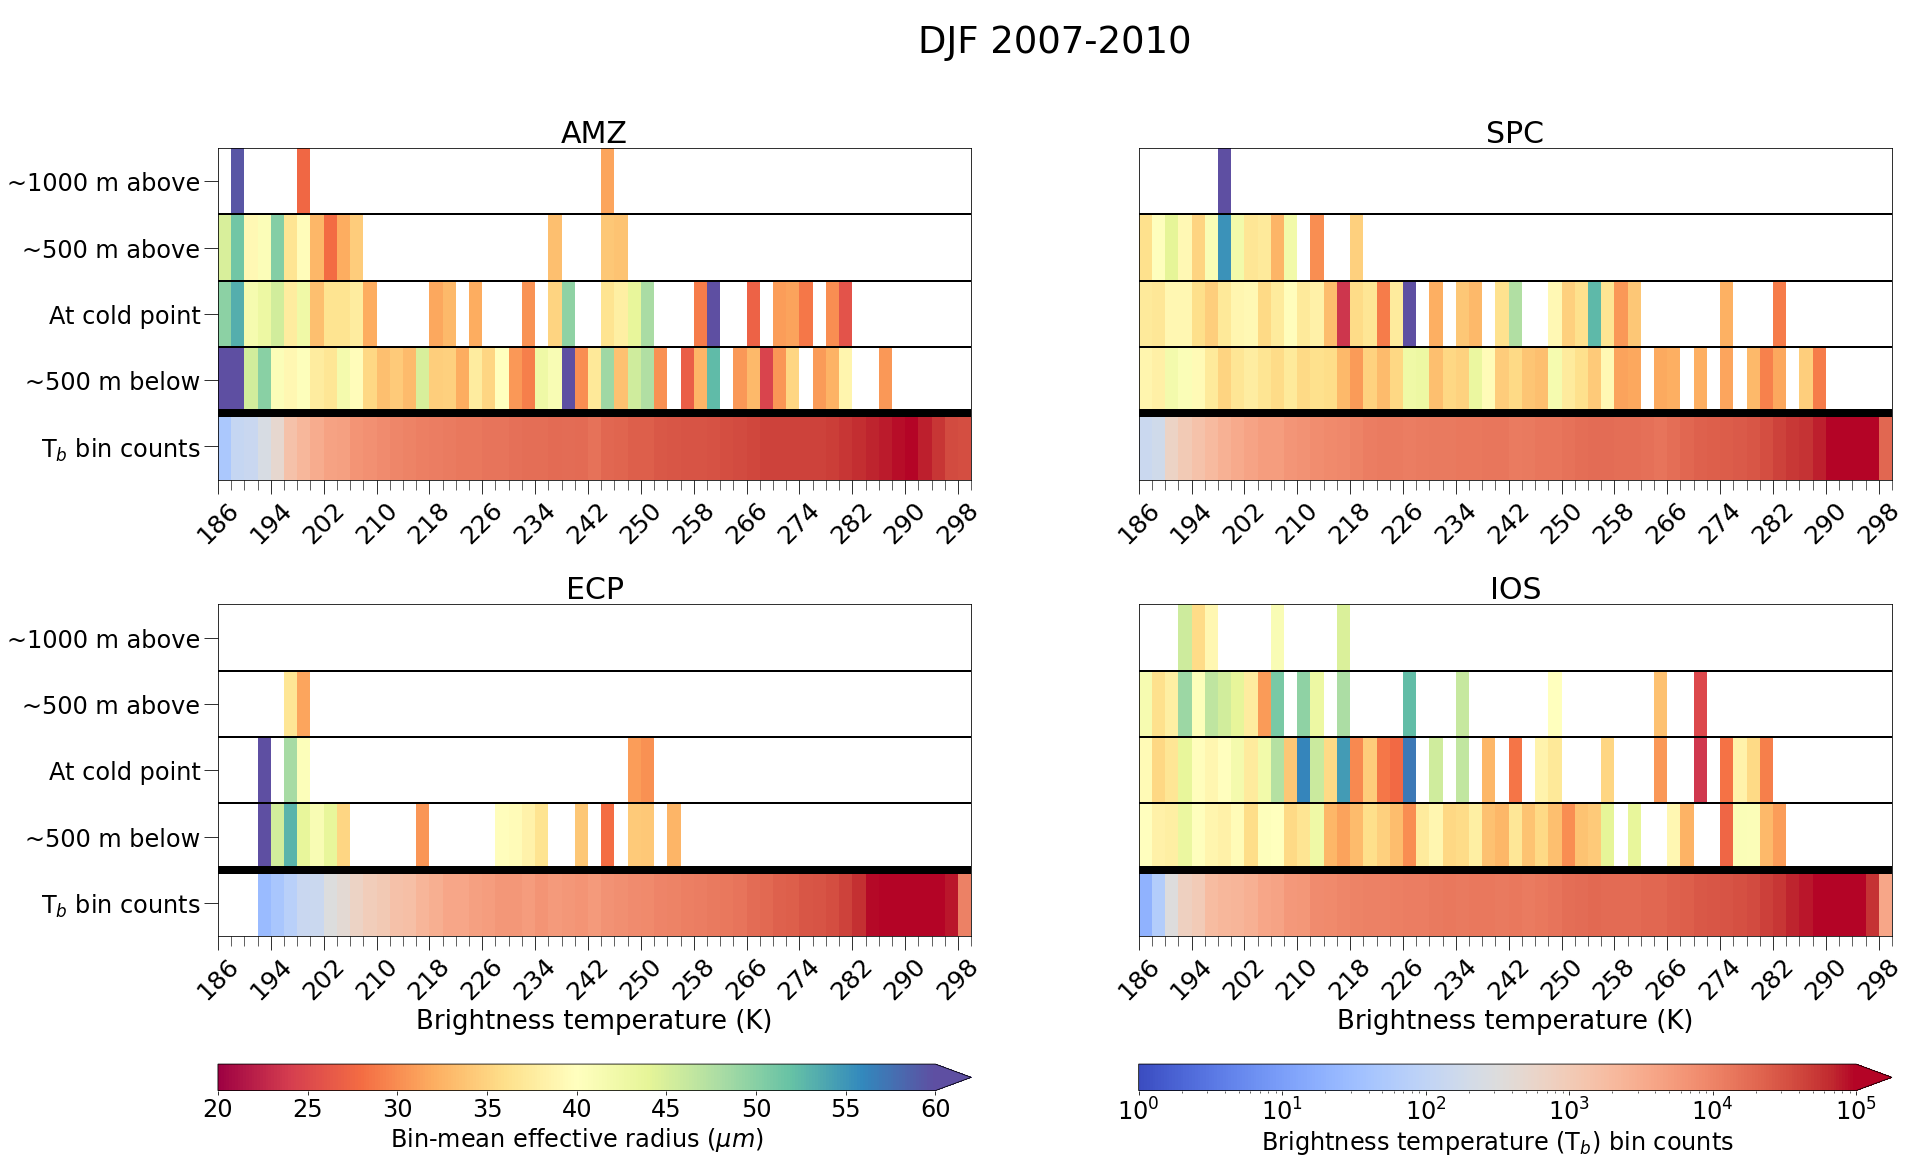

In [10]:
# DJF

plot_binned_by_tb_gs(qi_means_dict, region_tb_counts_dict, "mean", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, stat_lims=qi_lims, figsize=figsize,
                    tb_count_lims=count_lims)
plot_binned_by_tb_gs(qi_counts_dict, region_tb_counts_dict, "count", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, stat_lims=count_lims, figsize=figsize,
                    tb_count_lims=count_lims)

plot_binned_by_tb_gs(qi3_means_dict, region_tb_counts_dict, "mean", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, save_extr="_both_instr",
                      stat_lims=qi_lims, figsize=figsize, tb_count_lims=count_lims)
plot_binned_by_tb_gs(qi3_counts_dict, region_tb_counts_dict, "count", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, stat_lims=count_lims, save_extr="_both_instr",
                        figsize=figsize, tb_count_lims=count_lims)

plot_binned_by_tb_gs(re_means_dict, region_tb_counts_dict, "mean", season, years_str, tb_bins,
                      save=save_plots, save_dir=plot_save_dir, save_extr="_both_instr",
                      varname="reff", lognorm=False, stat_lims=reff_lims, figsize=figsize, tb_count_lims=count_lims)
    

## All relative levels, individually (previous plots)

In [9]:
def plot_binned_by_tb_with_count(bin_dict, tb_dar, tb_counts, statistic, month, region, year, bins,
                                  stat_lims=None, fsize=26, tsize=30, figsize=[13, 6], tb_count_lims=(1, 1000),
                                   colormap="Spectral", cbar_ext="max", lognorm=True, save=False,
                                  save_dir=None, varname="qi", save_extr=""): 
    """
    Plot DARDAR qi values binned by MERGIR brightness temperatures at levels relative to the cold 
    point. Variable "statistic" is "count" or "mean". Plots the Tb bin count at the bottom instead of
    the -1000m level.
    """
    figsize = [18, 6] 
    if varname == "qi":
        long_name = "cloud ice"
        units = "kg/kg"
    elif varname == "reff":
        long_name = "eff. radius"
        units = "$\mu m$"
        
    if stat_lims is None:
        if statistic == "mean":
            if varname == "reff":
                stat_lims = (0, 100)
            elif varname == "qi":
                stat_lims = (1e-6, 5e-4)
        elif statistic == "count":
            stat_lims = (1, 1000)

    
    ind_offsets = [-2, -1, 0, 1, 2]  
    offset_labs = [
        "Tb bin counts",
        "~500 m below",
        "At cold point",
        "~500 m above",
        "~1000 m above"
    ]
    
    # PLOT!
    fig, ax1 = plt.subplots(figsize=figsize)
    plt.subplots_adjust(hspace=0.5)
    bin_mean_values = (bins[:-1] + bins[1:])/2
            
    # turn the dict values into arrays
    bin_dict_arr = np.array(list(bin_dict.values()))[1:, :]
    if varname == "reff":
        bin_dict_arr = bin_dict_arr*1e6 # convert from m --> um
        
    # --- binned data ---
    if lognorm:
        pcm = ax1.pcolormesh(bin_mean_values, ind_offsets[1:], bin_dict_arr, cmap=colormap,
                             norm=mcolors.LogNorm(vmin=stat_lims[0], vmax=stat_lims[1])
                            )
    else:
        pcm = ax1.pcolormesh(bin_mean_values, ind_offsets[1:], bin_dict_arr, cmap=colormap,
                             vmin=stat_lims[0], vmax=stat_lims[1]
                            )
    cb = plt.colorbar(pcm, ax=ax1, fraction=0.046, pad=0.04, extend=cbar_ext)
    cb.ax.tick_params(labelsize=fsize-3)
    if statistic == "count":
        cb.set_label("Bin counts", fontsize=fsize-3)
    elif statistic == "mean":
        cb.set_label("Bin-mean {n} ({u})".format(n=long_name, u=units), fontsize=fsize-3)
        
    # --- Tb bin counts ---
    tiled_counts = np.zeros((len(ind_offsets), len(tb_counts)))
    tiled_counts[0, :] = tb_counts
    tiled_counts[1:, :] = np.nan
    # pcm2 = ax1.pcolormesh(bin_mean_values, ind_offsets[:1], np.reshape(tb_counts, (1, len(tb_counts))), 
    pcm2 = ax1.pcolormesh(bin_mean_values, ind_offsets, tiled_counts,
                          cmap="coolwarm", norm=mcolors.LogNorm(vmin=tb_count_lims[0], vmax=tb_count_lims[1])
                            # cmap="coolwarm", vmin=tb_count_lims[0], vmax=tb_count_lims[1]

                        )
    cb2 = plt.colorbar(pcm2, ax=ax1, fraction=0.046, pad=0.04, extend="max")
    cb2.ax.tick_params(labelsize=fsize-3)
    cb2.set_label("Tb bin counts", fontsize=fsize-3)
        
    ax1.set_xlabel("Brightness temperature (K)", fontsize=fsize)
    ax1.set_yticks(ind_offsets)
    ax1.set_yticklabels(offset_labs)
    ax1.tick_params(axis="y", labelsize=fsize-2, length=0)
    ax1.set_xticks(bins[::4])        
    ax1.tick_params(axis="x", rotation=45, labelsize=fsize-1)
    ax1.xaxis.set_minor_locator(mticker.MultipleLocator(2))
    ax1.tick_params(which='minor', length=10)
    ax1.tick_params(which='major', length=14)
    
    plt.suptitle("{m} {y} ({r})".format(m=month, y=year, r=region), fontsize=tsize)


    # add horizontal borders
    for ind in ind_offsets[:-1]:
        if ind == -2:
            lw = 8
        else:
            lw = 2
        gap = 0.5
        ax1.axhline(ind+0.5, color="k", linewidth=lw)


    if save:
        if save_dir is None:
            raise Exception("Must provide save_dir if you want to save the plot")           
        plt.savefig(save_dir + "DARDAR_{v}_binned_by_Tb_with_counts_{s}_{m}{y}_{r}{e}.png".format(
                                                                                            v=varname, s=statistic,
                                                                                            m=month, y=year, 
                                                                                            r=region, e=save_extr,
                                                                                        ),
                    dpi=300, bbox_inches="tight"
                   )

    plt.show()
    

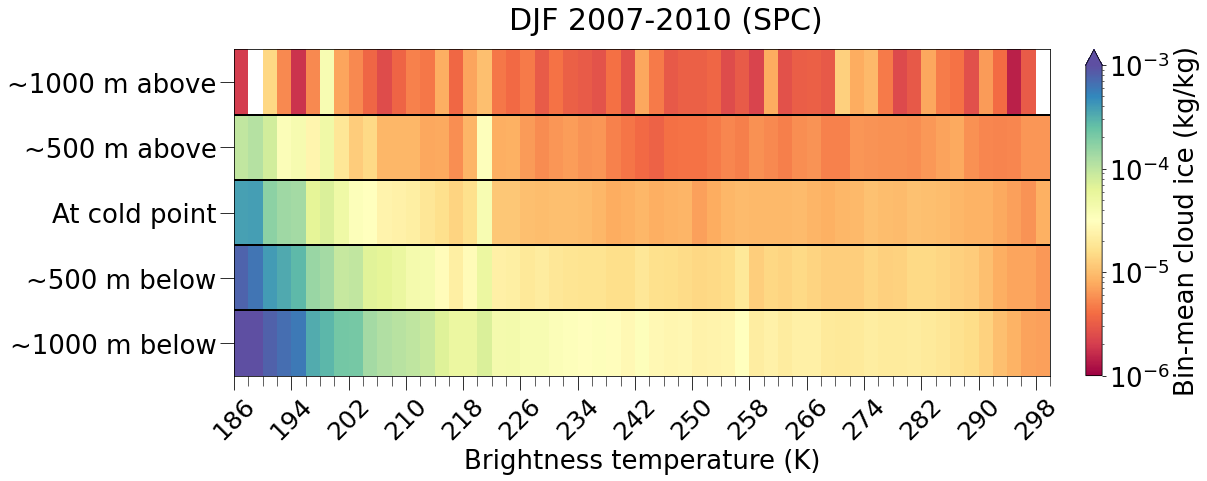

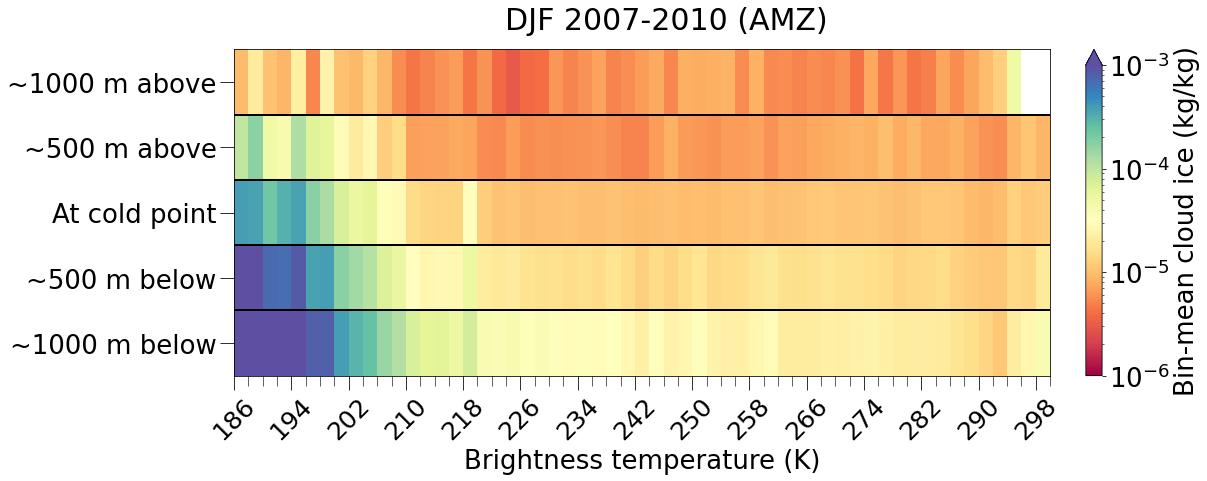

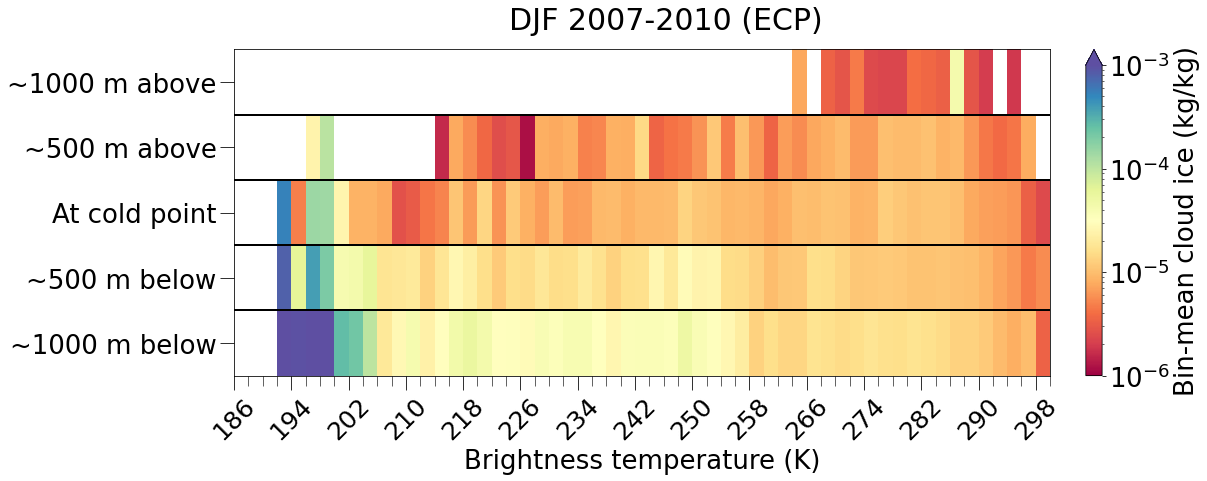

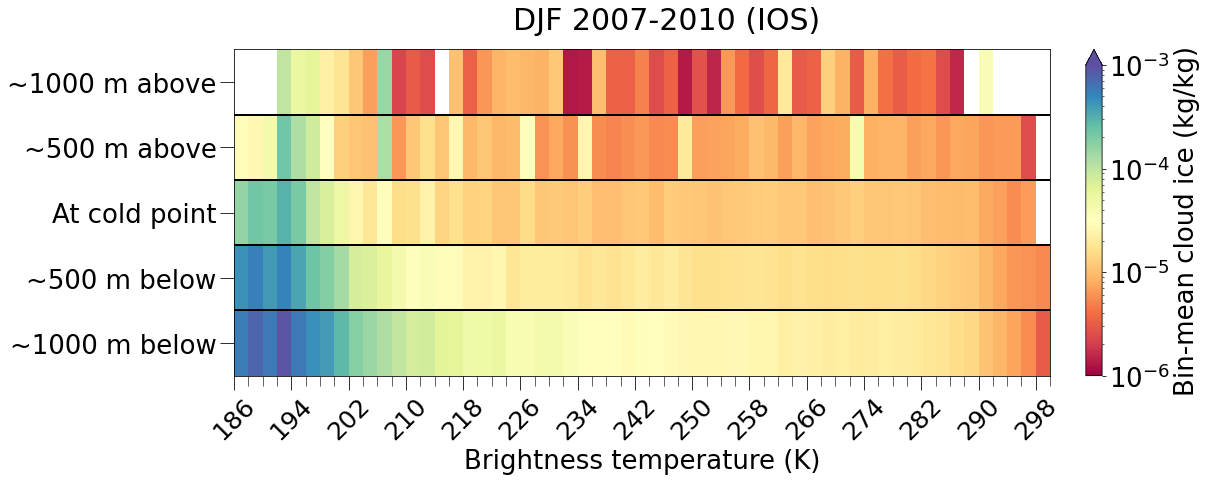

In [13]:
#DJF
for region in region_list:
    # bin mean ice for all
    boo.plot_binned_by_tb(qi_means_dict[region], tb_dict[region], "mean", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, stat_lims=qi_lims)


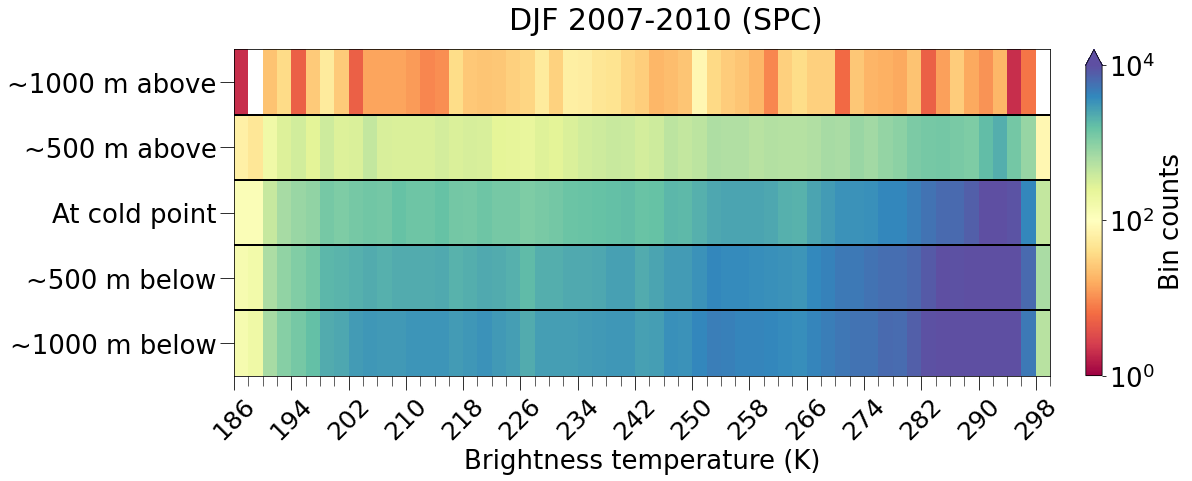

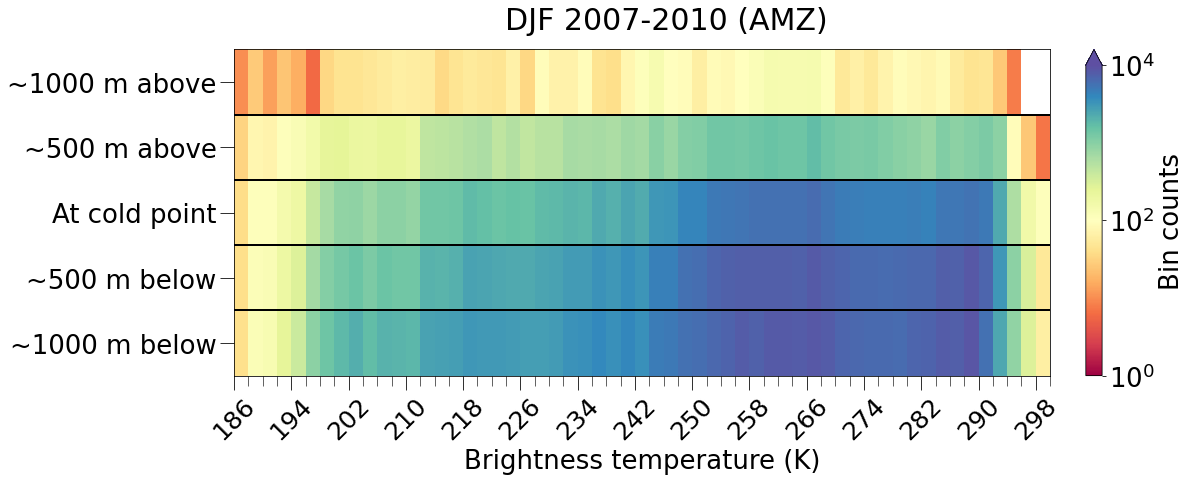

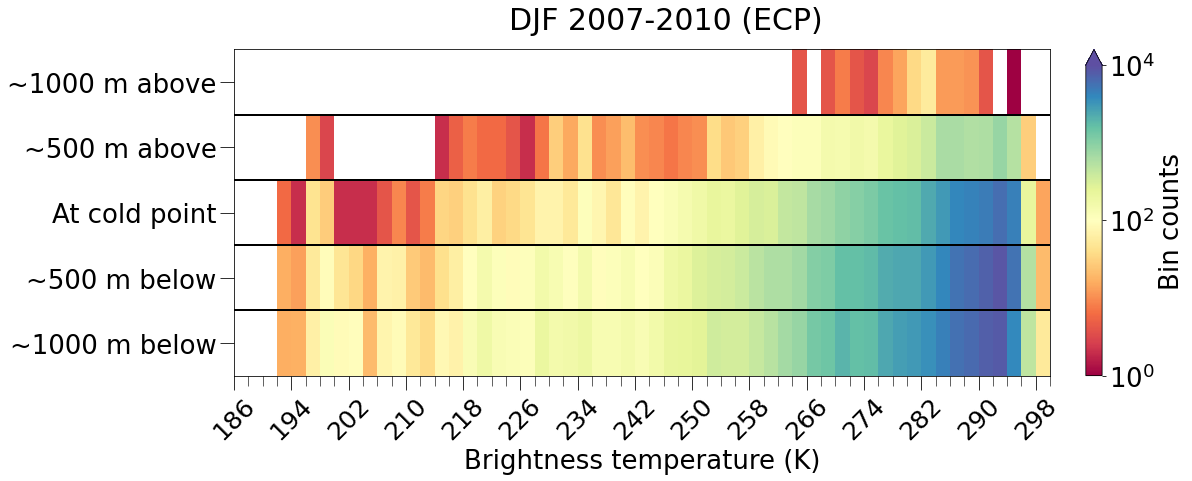

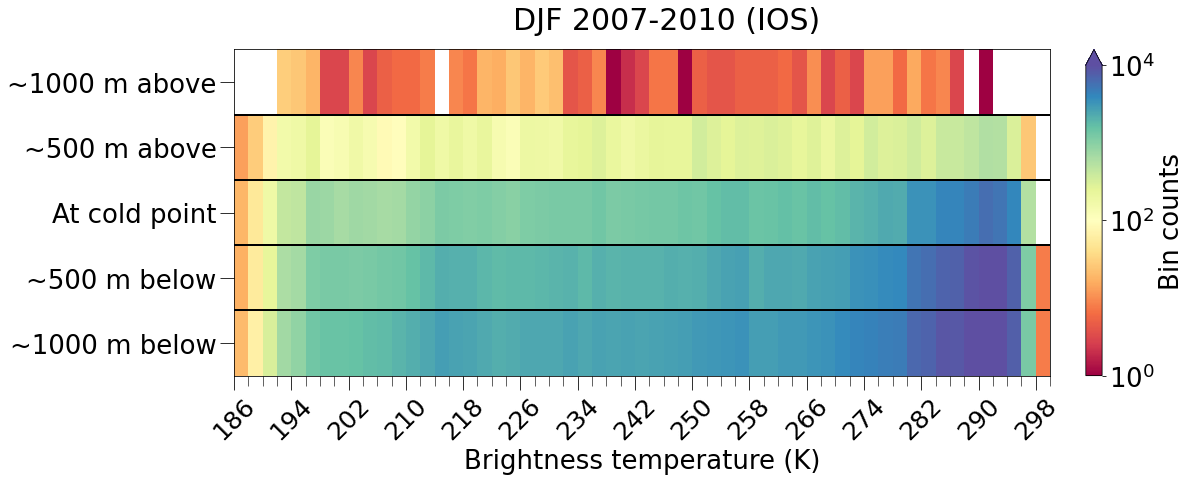

In [15]:
#DJF
for region in region_list:
    # bin mean COUNTS for all
    boo.plot_binned_by_tb(qi_counts_dict[region], tb_dict[region], "count", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, stat_lims=count_lims)


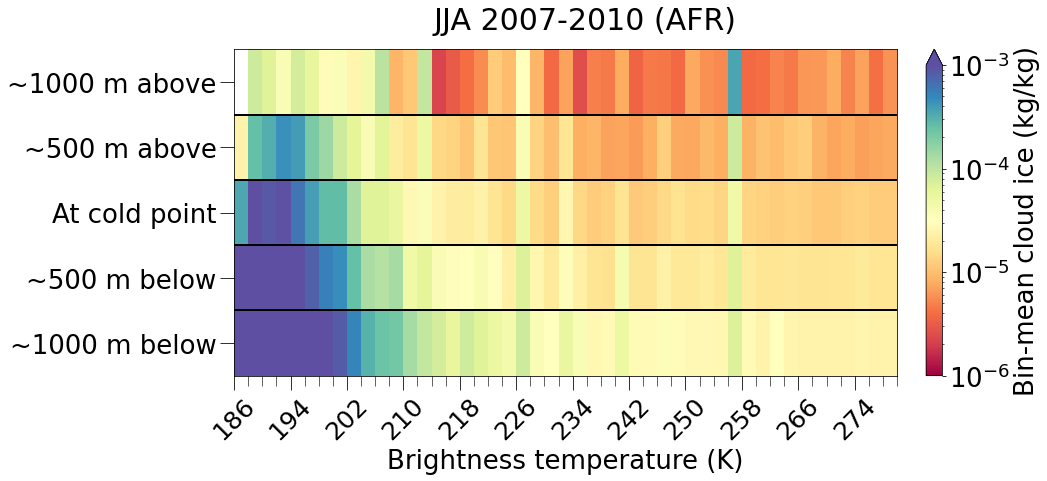

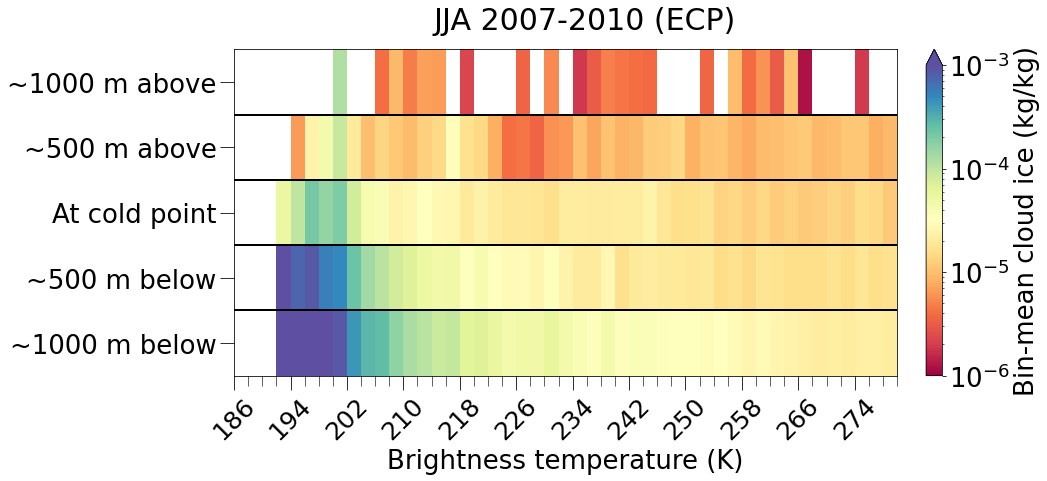

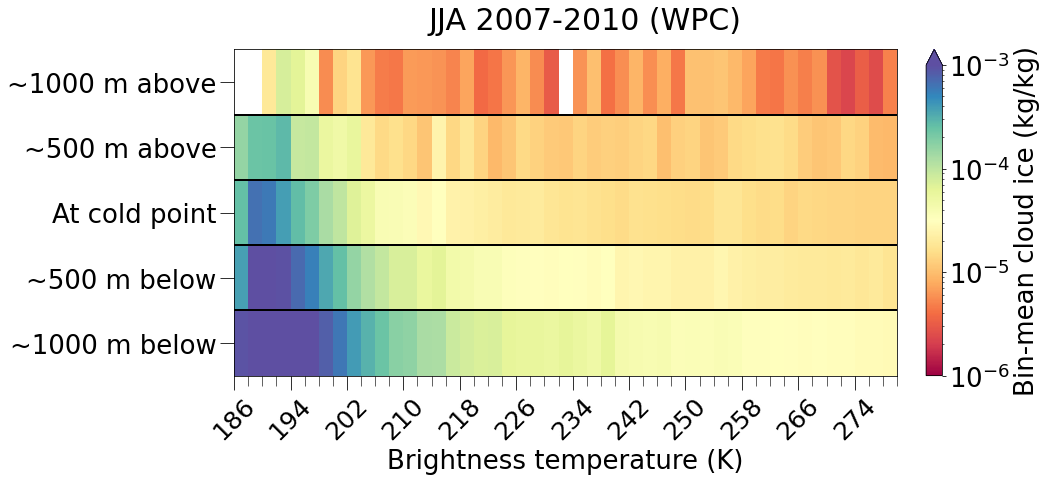

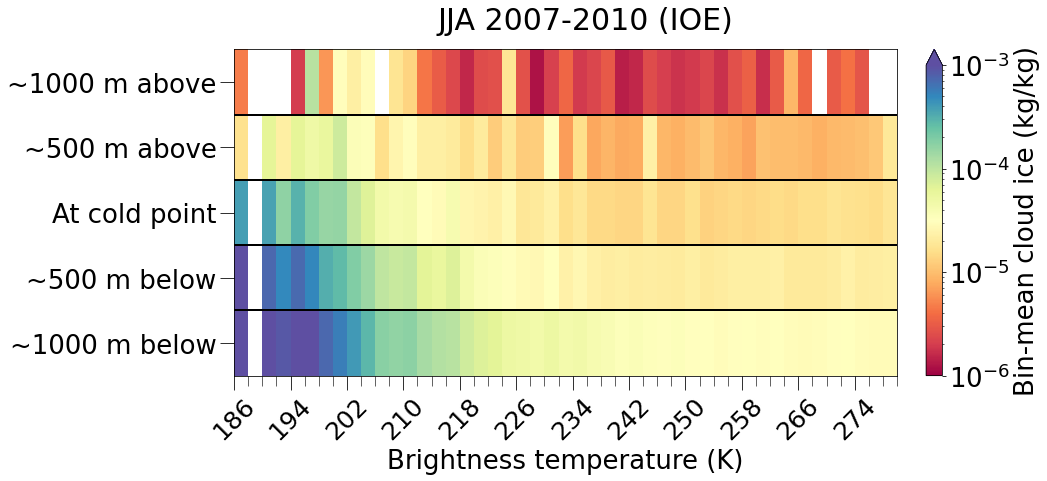

In [8]:
#JJA
for region in region_list:
    # bin mean ice for all
    boo.plot_binned_by_tb(qi_means_dict[region], tb_dict[region], "mean", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, stat_lims=qi_lims)


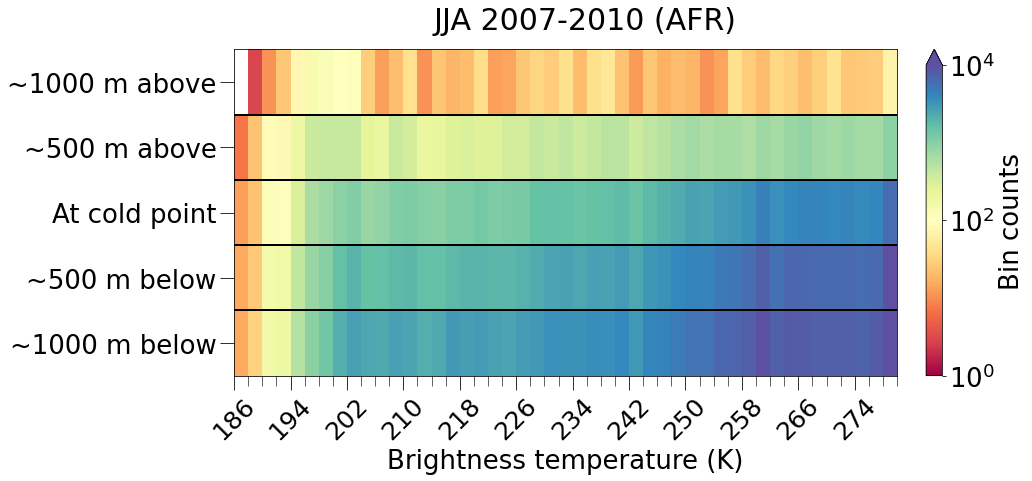

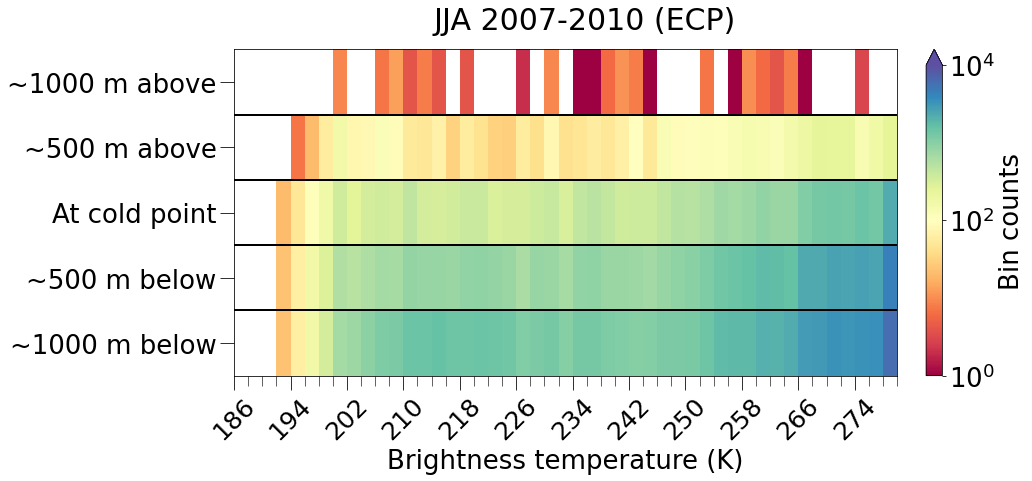

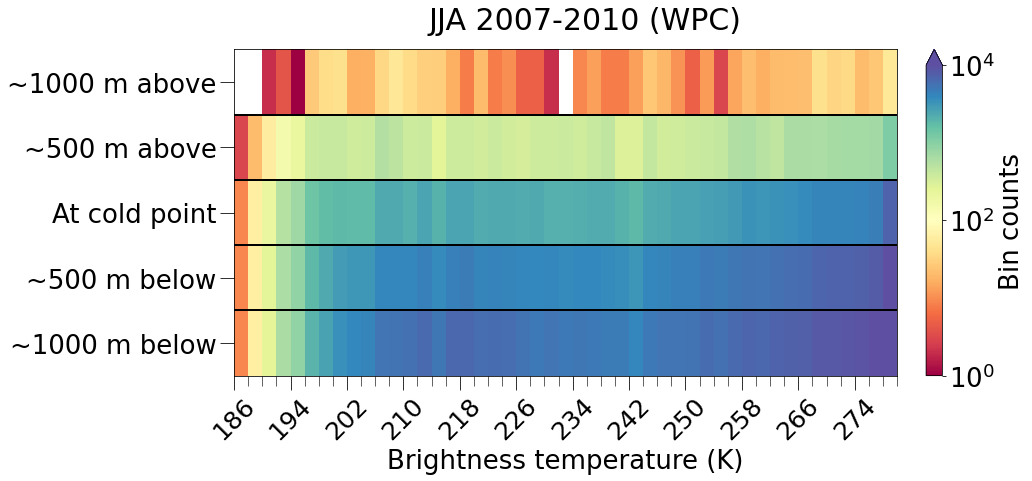

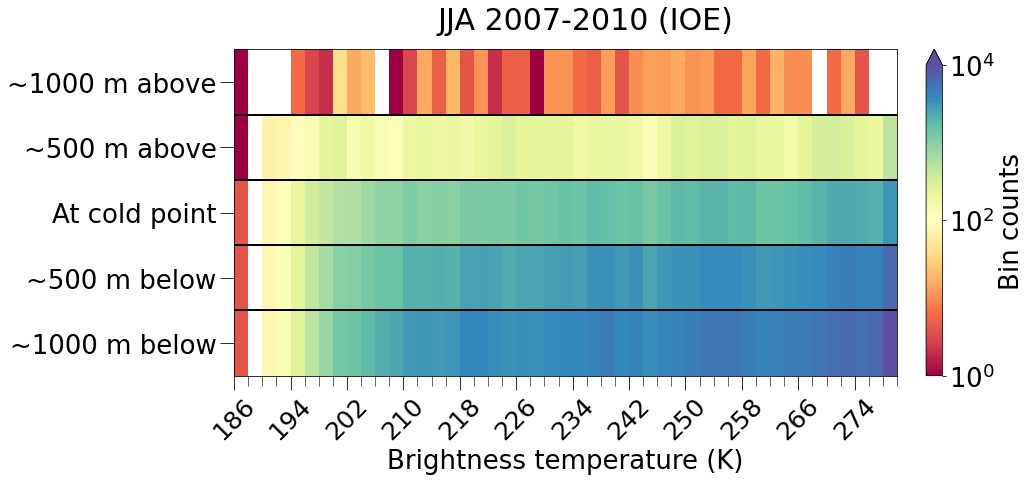

In [9]:
#JJA
for region in region_list:
    # bin mean COUNTS for all
    boo.plot_binned_by_tb(qi_counts_dict[region], tb_dict[region], "count", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, stat_lims=count_lims)


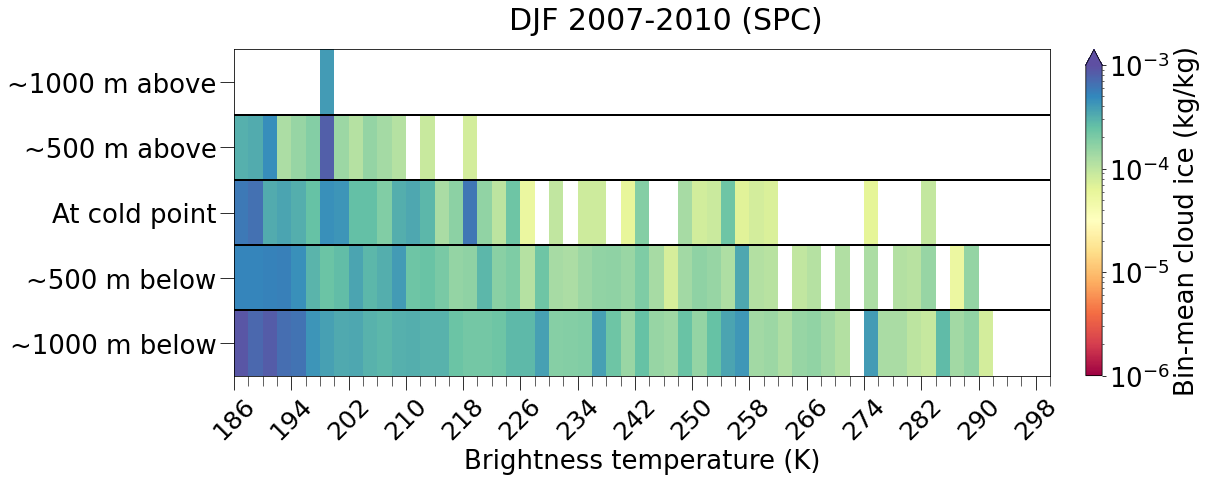

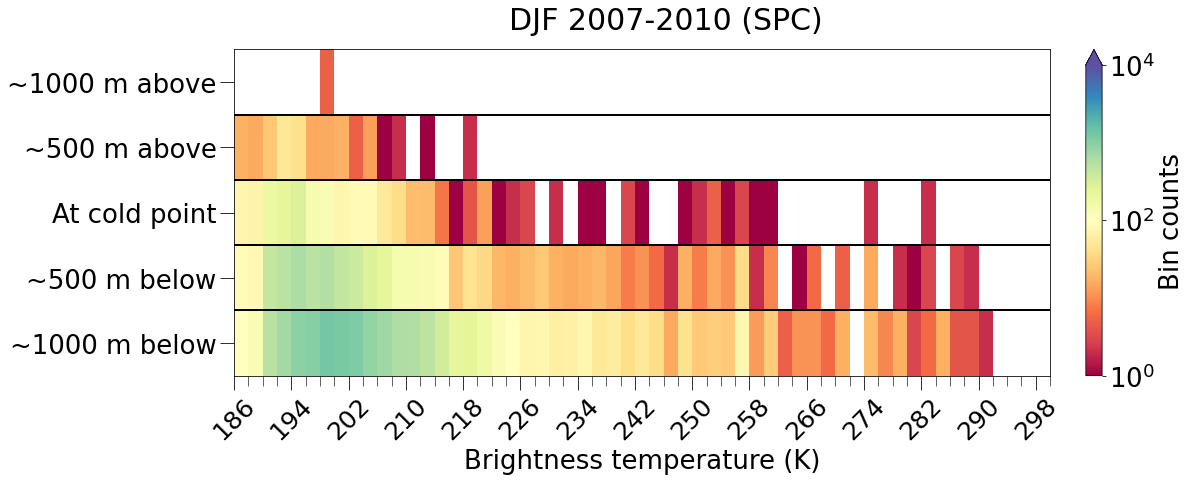

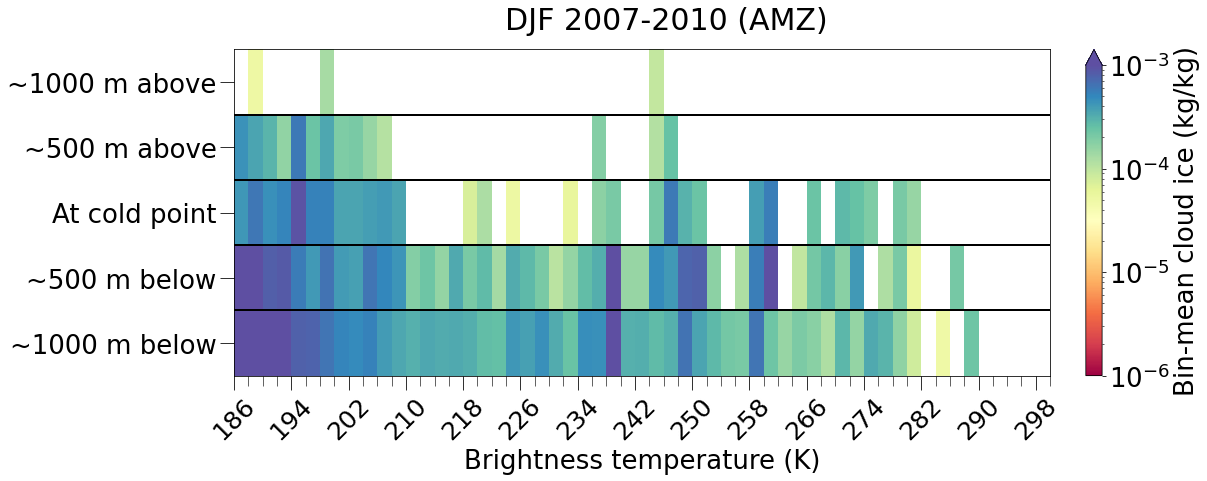

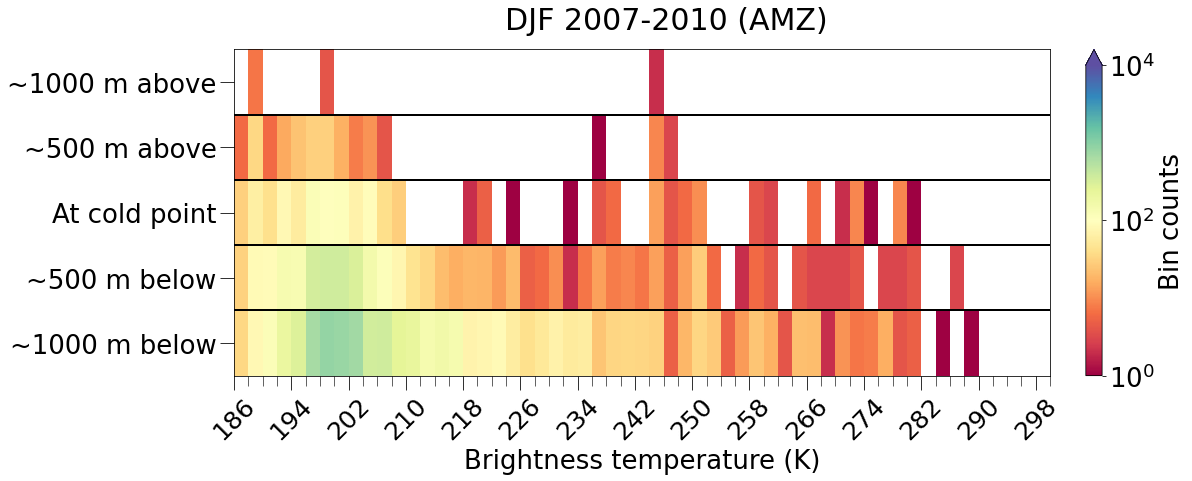

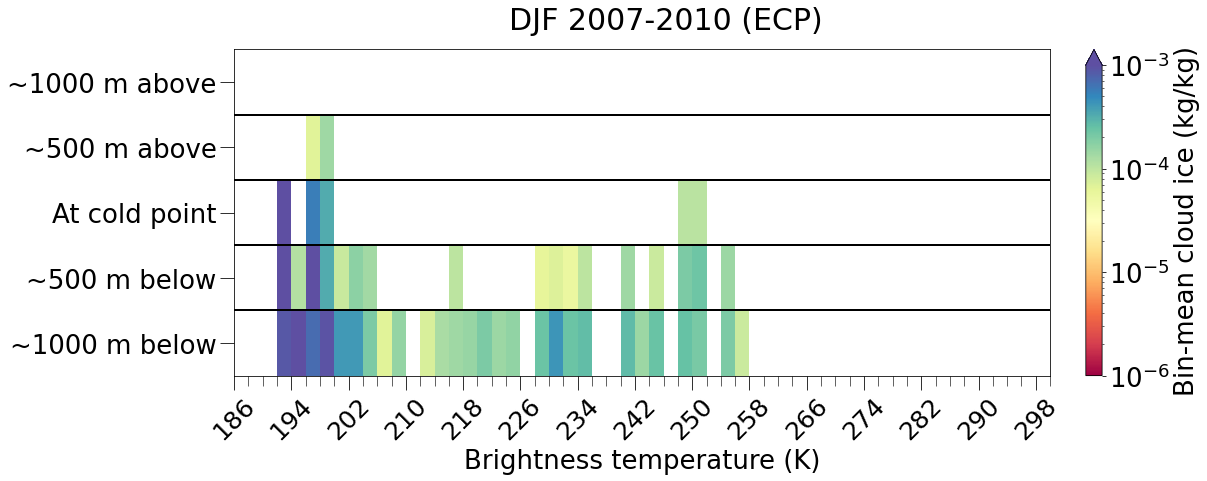

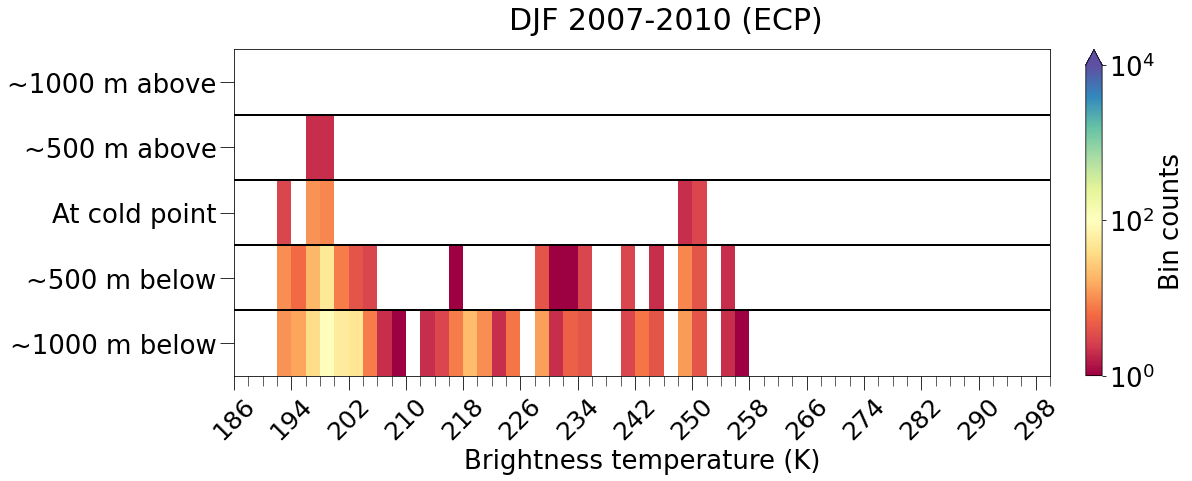

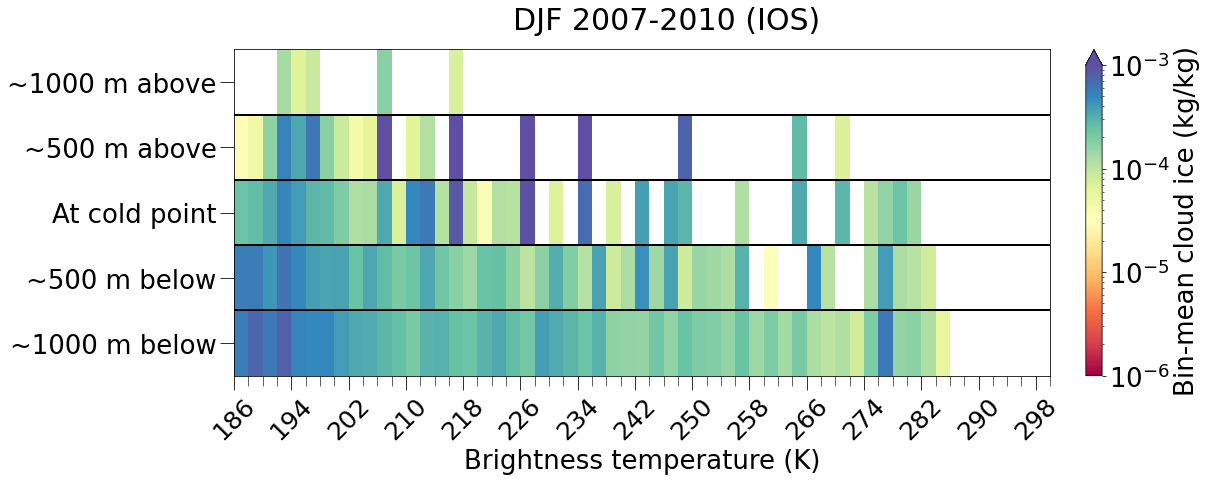

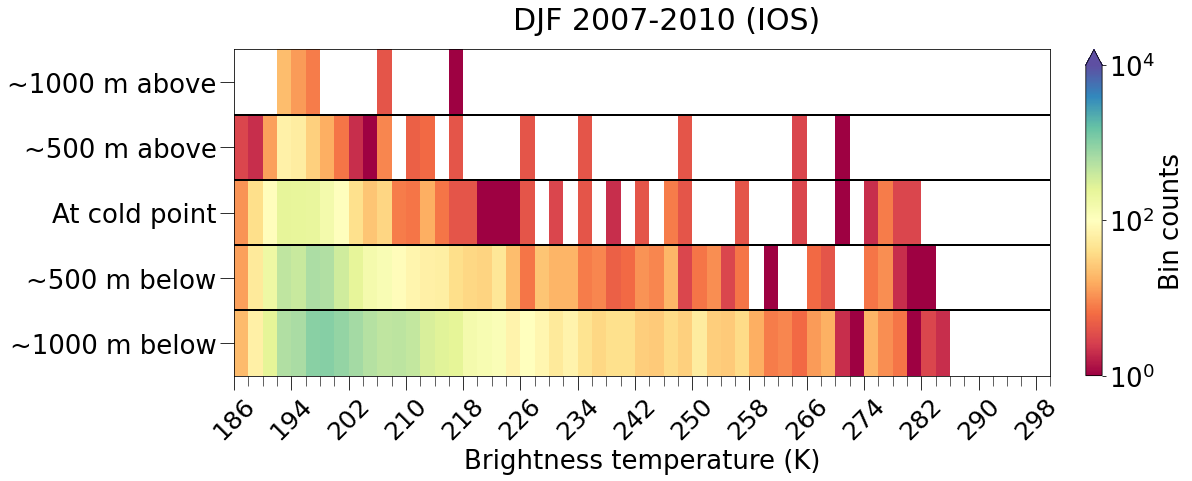

In [16]:
# DJF
for region in region_list:
    # bin mean ice and bin counts for when both instruments are operating
    boo.plot_binned_by_tb(qi3_means_dict[region], tb_dict[region], "mean", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, save_extr="_both_instr",
                          stat_lims=qi_lims)
    boo.plot_binned_by_tb(qi3_counts_dict[region], tb_dict[region], "count", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, stat_lims=count_lims, save_extr="_both_instr")


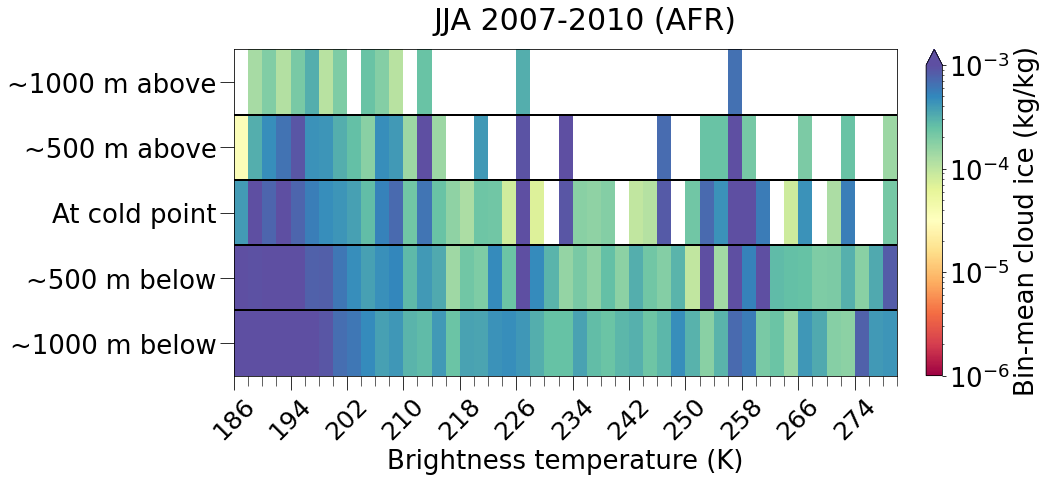

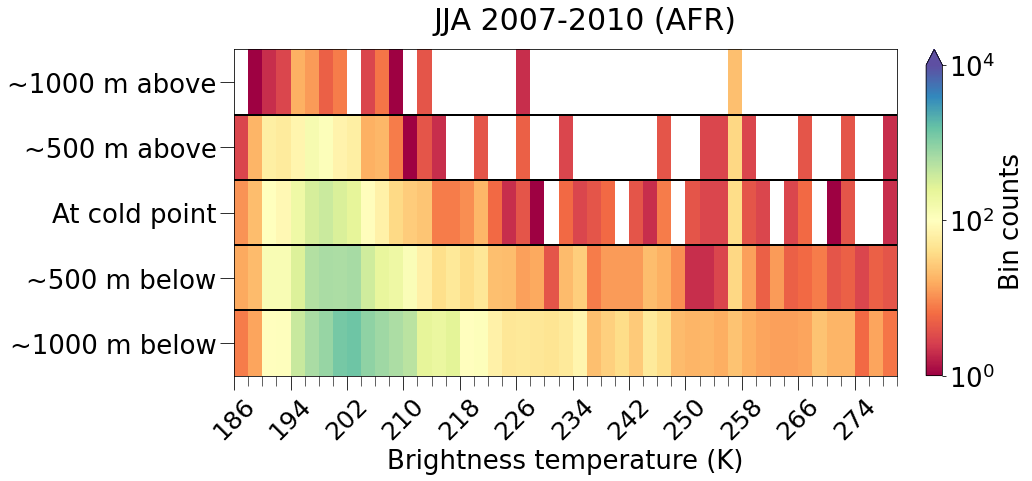

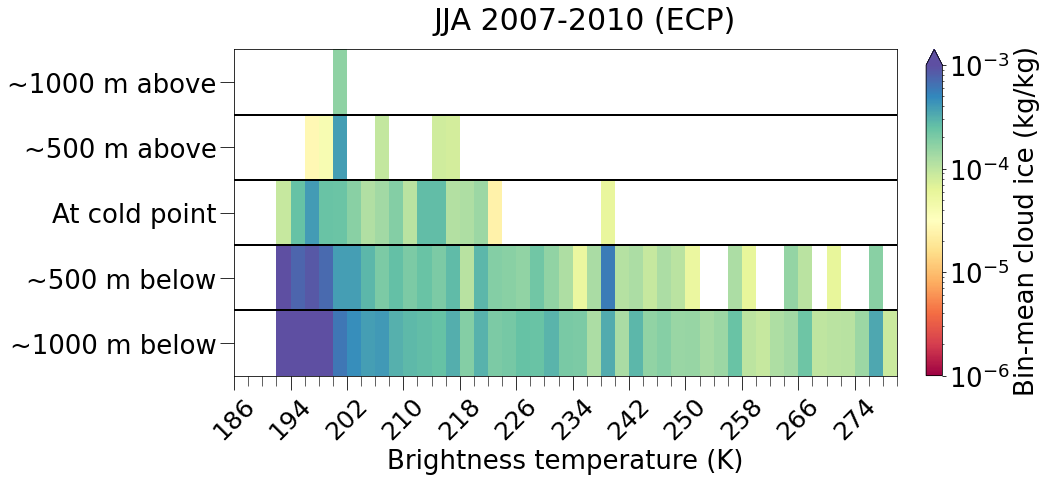

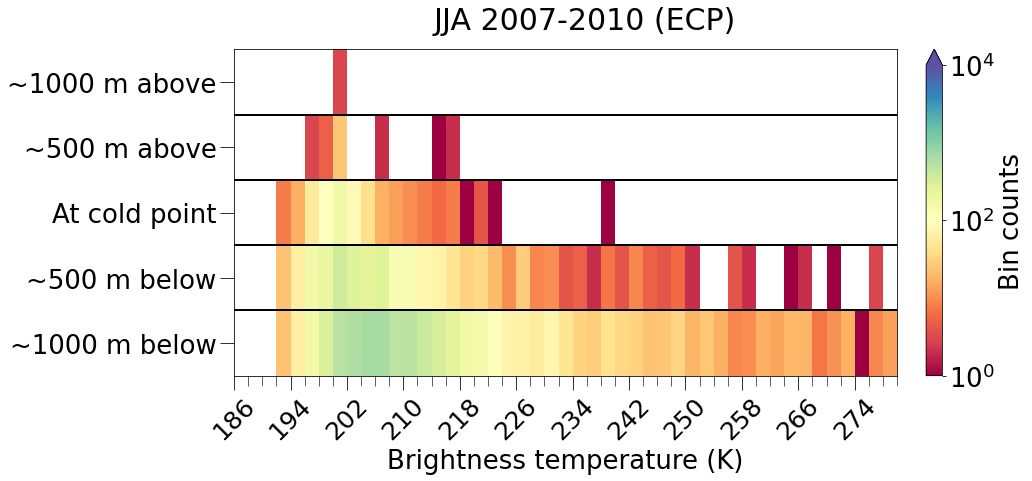

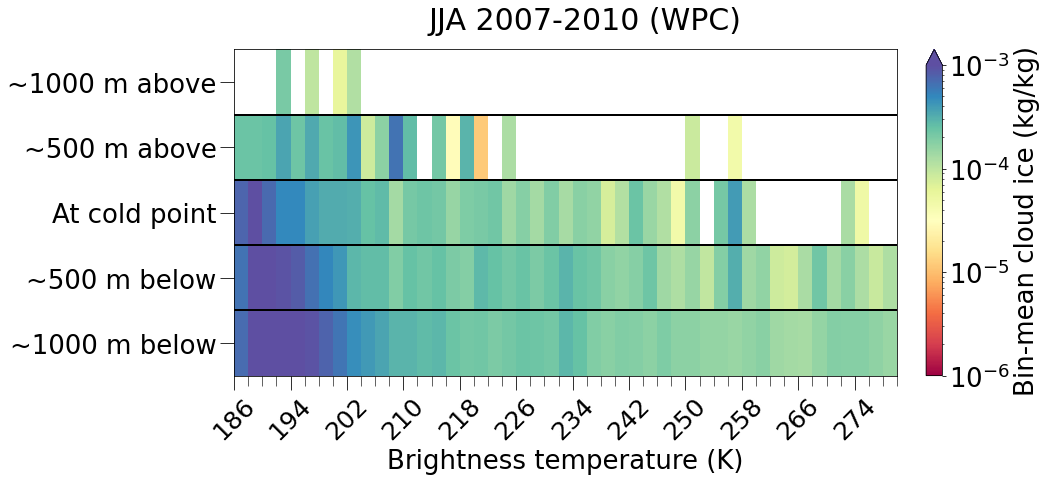

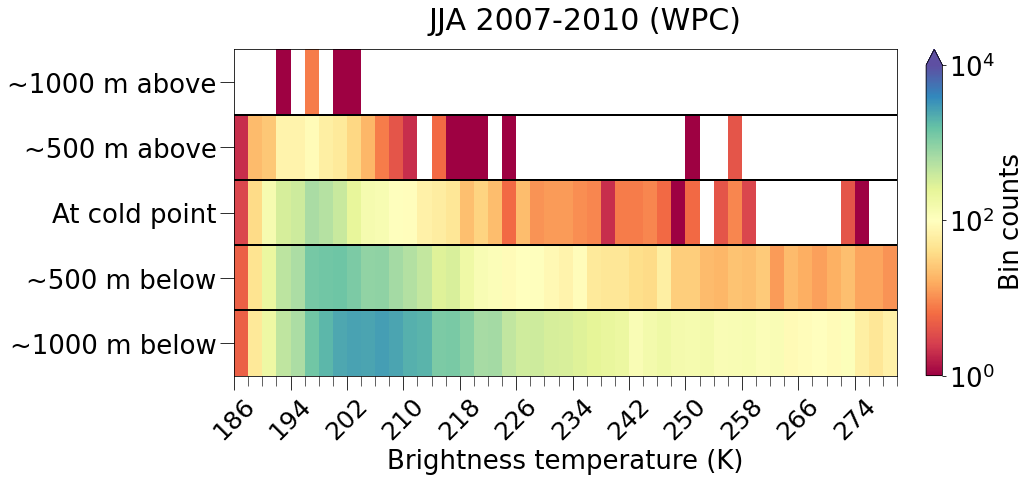

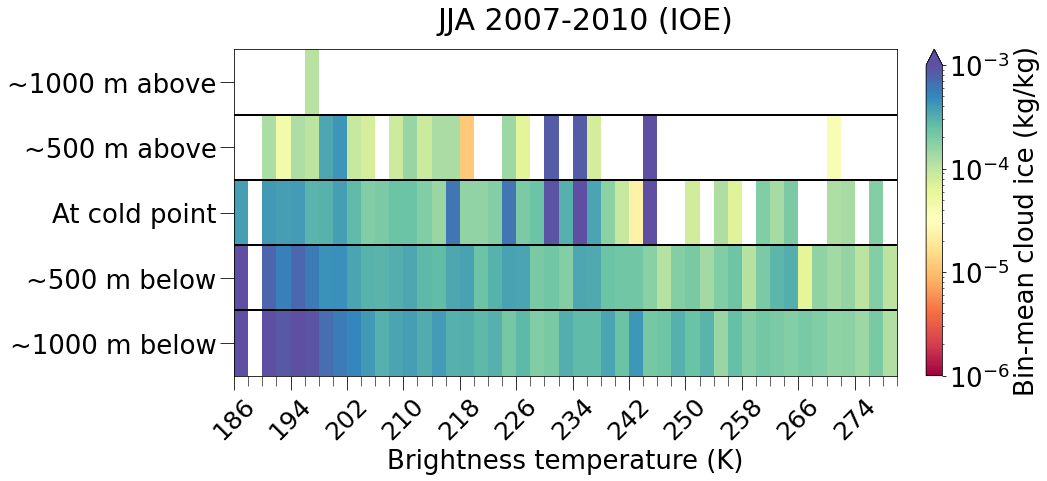

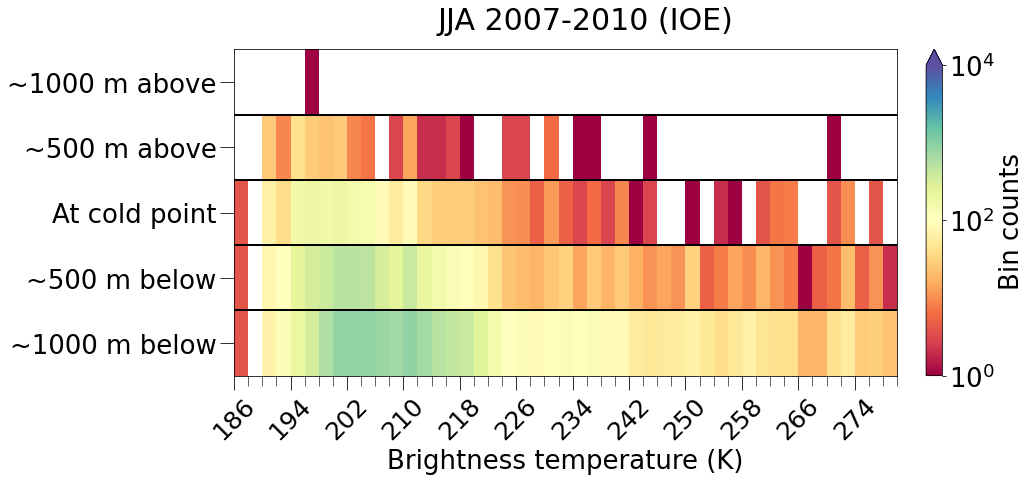

In [10]:
# JJA
for region in region_list:
    # bin mean ice and bin counts for when both instruments are operating
    boo.plot_binned_by_tb(qi3_means_dict[region], tb_dict[region], "mean", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, save_extr="_both_instr",
                          stat_lims=qi_lims)
    boo.plot_binned_by_tb(qi3_counts_dict[region], tb_dict[region], "count", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, stat_lims=count_lims, save_extr="_both_instr")


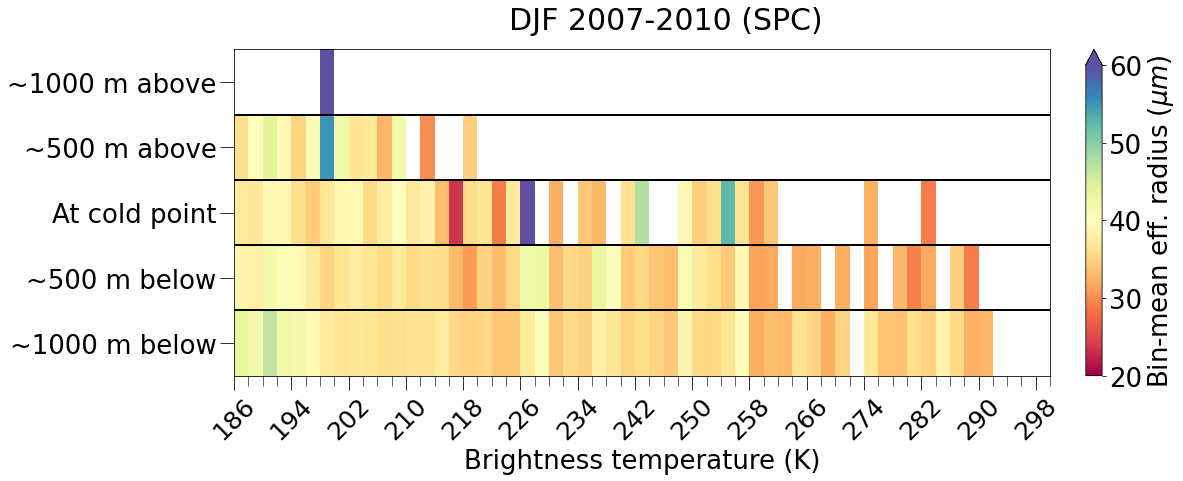

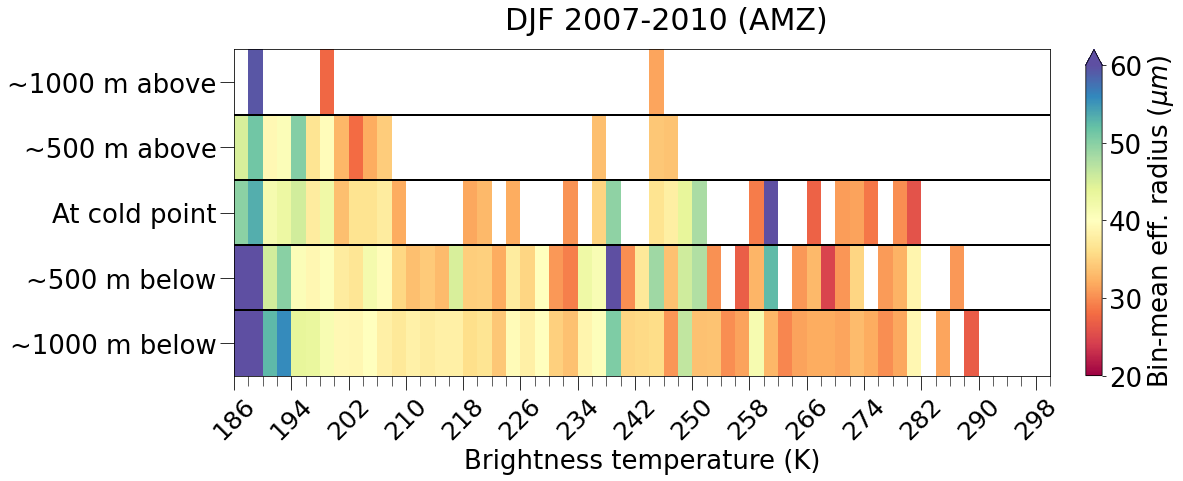

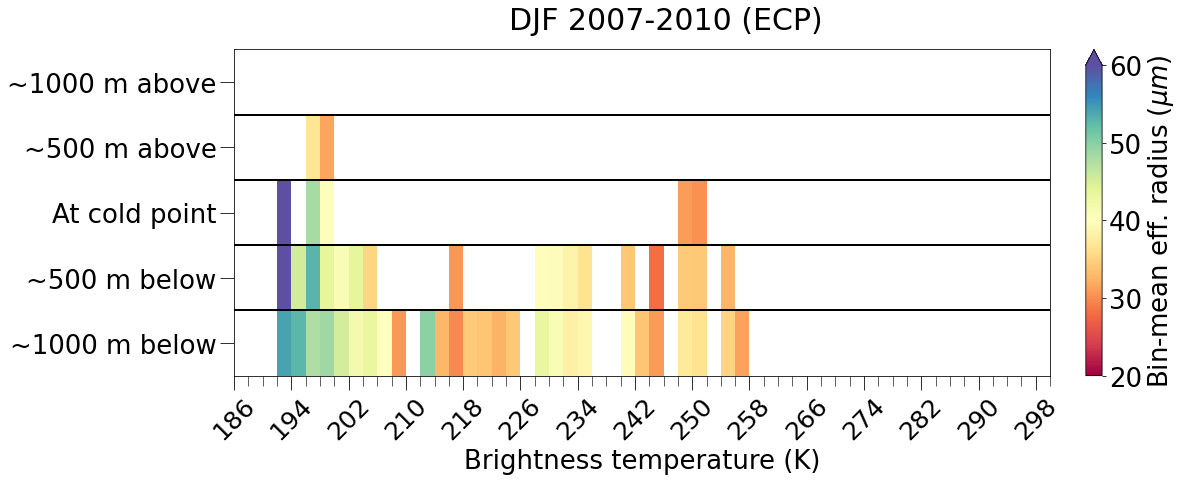

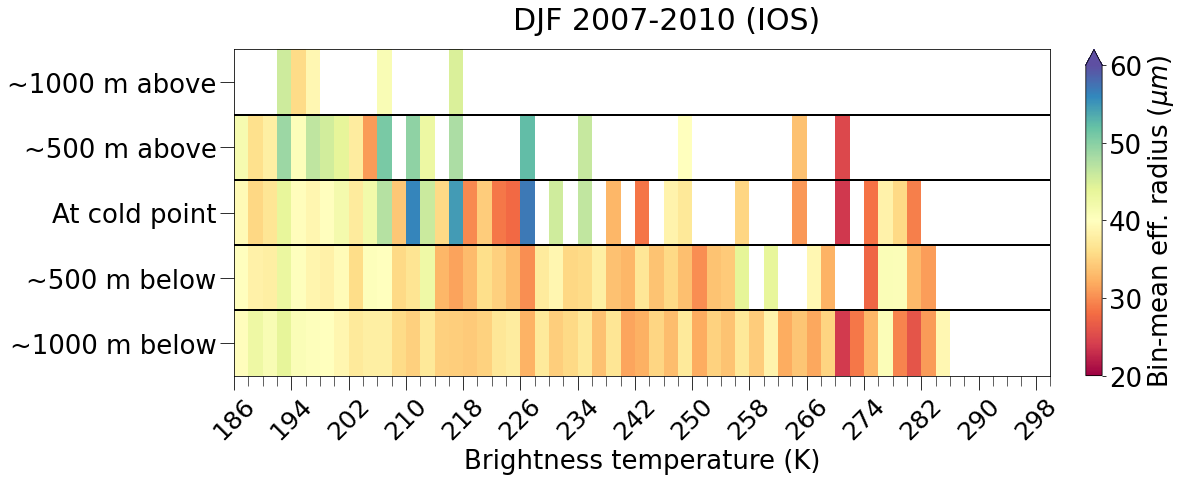

In [21]:
# DJF

for region in region_list:
# bin mean effective radius for when both instruments are operating
    boo.plot_binned_by_tb(re_means_dict[region], tb_dict[region], "mean", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, save_extr="_both_instr",
                          varname="reff", lognorm=False, stat_lims=reff_lims)


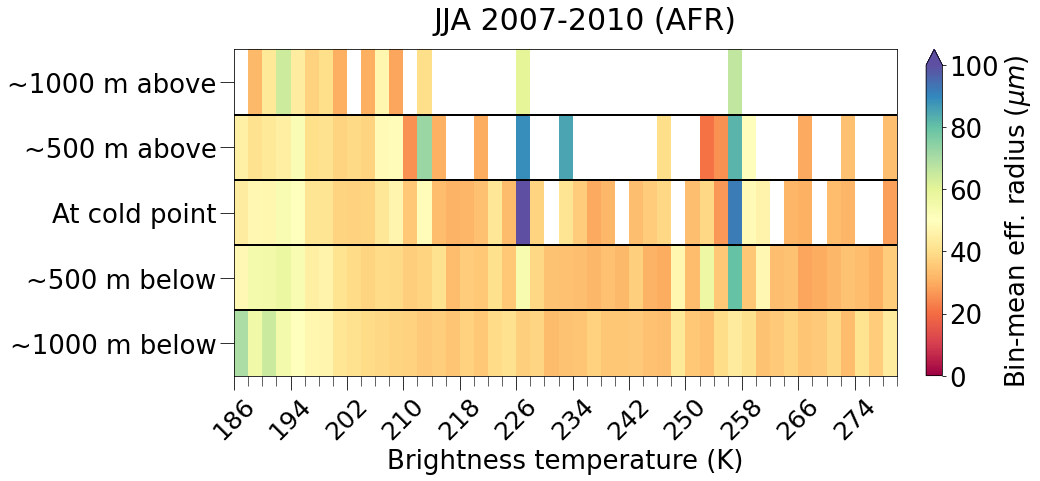

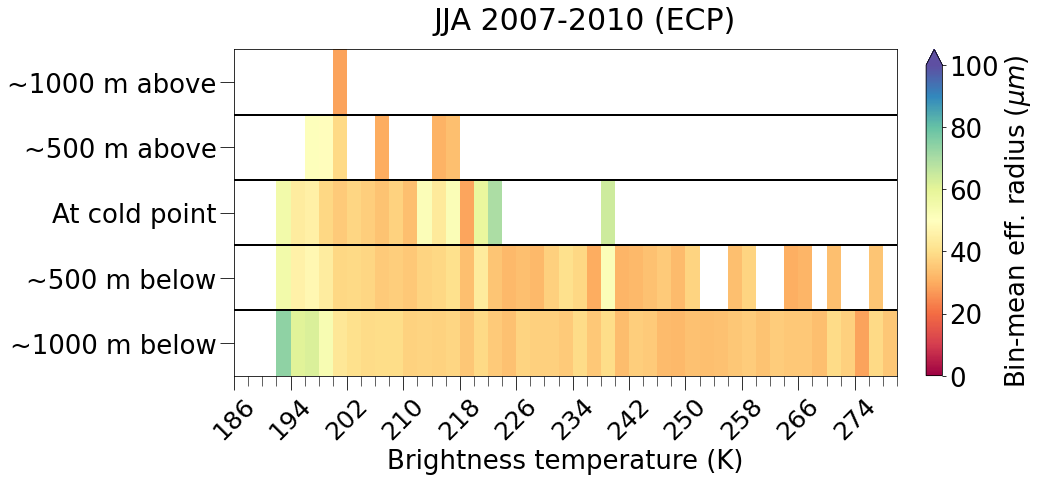

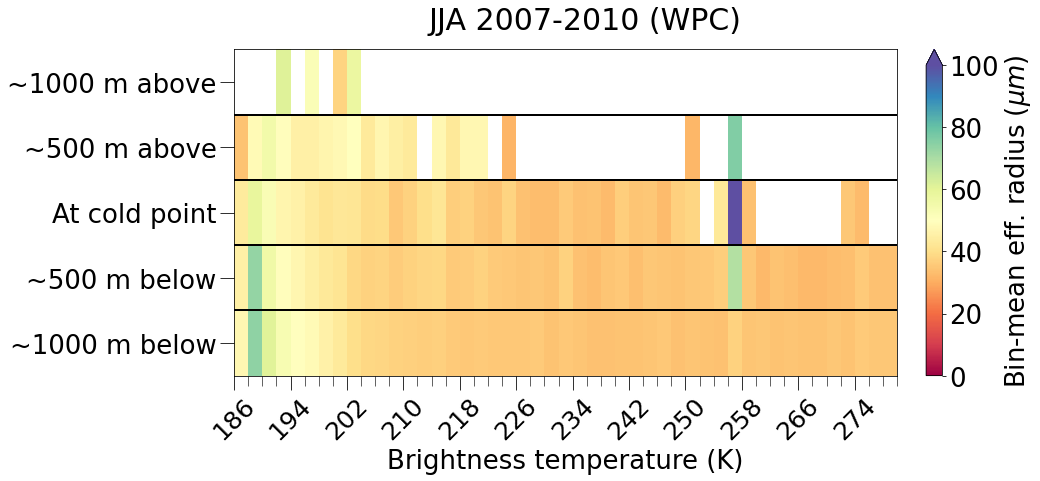

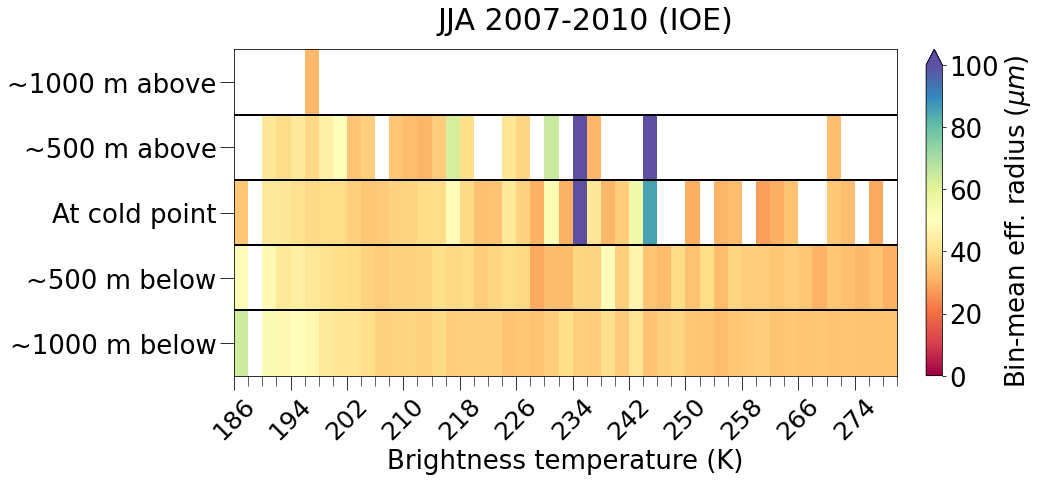

In [11]:
# JJA

for region in region_list:
# bin mean effective radius for when both instruments are operating
    boo.plot_binned_by_tb(re_means_dict[region], tb_dict[region], "mean", season, region, years_str,
                          save=save_plots, save_dir=plot_save_dir, save_extr="_both_instr",
                          varname="reff", lognorm=False, stat_lims=reff_lims)
